In this notebook, we can explore the data a bit more thoroughly. We load all precomputed datasets and can make several plots.
- We can check the percentages per allele,site for each cell.
- We can check the allele counts per allele,site for each cell.
- We can make heatmaps with allele/sites on the x-axis and cells on the y-axis. Every colour represents a different scar. This gives a nice overview of the complexity of the data, the fraction of WT sequences and the amount of missing data.
- We can cluster the cells based on their scar profile using IWSS.
- We can plot clusters of cells with similar scar profiles on top of the transciptome umap to see which cell types are found in which clusters.

# Import all relevant packages

In [3]:
#import all 
%matplotlib inline
import matplotlib
import sys, os
from pandas.io.parsers import read_csv
import numpy as np
import seaborn as sns
import pandas as pd
import sklearn.cluster as cluster
import matplotlib.pyplot as plt
import collections
import scipy
import itertools
#import floweaver
np.warnings.filterwarnings('ignore')
import pysam
import pyBigWig as bw
#%load_ext rpy2.ipython
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

ModuleNotFoundError: No module named 'pyBigWig'

# Load computed datasets

#### Here you can load all precomputed datasets.

In [2]:
pathToData = '/Users/m.blotenburg/Documents/Projects/Mouse_Scartrace/Data_analysis/Scar_analysis/20200414_VAN2988_remap_BWAfilters_AlleleCalling_maskedGenome/'

In [3]:
df = pd.read_pickle(pathToData + '120hAA_miseq_remapped_SQfiltered.pickle.gz')
df.head()

gastruloid                           C5A9                                    \
cell                                 A2_1 A2_10 A2_100 A2_101 A2_102 A2_103   
chrom allele site      scar                                                   
1     None   12847807  WT             NaN   NaN    NaN    NaN    NaN    NaN   
             12847810  WT             NaN   NaN    NaN    NaN    NaN    NaN   
             12847812  WT             NaN   NaN    NaN    NaN    NaN    NaN   
             143473230 143473407.D    NaN   NaN    NaN    NaN    NaN    NaN   
             143473231 T.143473171.I  NaN   NaN    NaN    NaN    NaN    NaN   

gastruloid                                                        ... C5F10  \
cell                                 A2_104 A2_105 A2_106 A2_107  ... H2_90   
chrom allele site      scar                                       ...         
1     None   12847807  WT               NaN    NaN    NaN    NaN  ...   NaN   
             12847810  WT               NaN    NaN    NaN    NaN  ...   NaN   
             12847812  WT               NaN    NaN    NaN    NaN  ...   NaN   
             143473230 143473407.D      NaN    NaN    NaN    NaN  ...   NaN   
             143473231 T.143473171.I    NaN    NaN    NaN    NaN  ...   NaN   

gastruloid                                                                \
cell                                 H2_91 H2_92 H2_93 H2_94 H2_95 H2_96   
chrom allele site      scar                                                
1     None   12847807  WT              NaN   NaN   NaN   NaN   NaN   NaN   
             12847810  WT              NaN   NaN   NaN   NaN   NaN   NaN   
             12847812  WT              NaN   NaN   NaN   NaN   NaN   NaN   
             143473230 143473407.D     NaN   NaN   NaN   NaN   NaN   NaN   
             143473231 T.143473171.I   NaN   NaN   NaN   NaN   NaN   NaN   

gastruloid                                              
cell                                 H2_97 H2_98 H2_99  
chrom allele site      scar                             
1     None   12847807  WT              NaN   NaN   NaN  
             12847810  WT              NaN   NaN   NaN  
             12847812  WT              NaN   NaN   NaN  
             143473230 143473407.D     NaN   NaN   NaN  
             143473231 T.143473171.I   NaN   NaN   NaN  

[5 rows x 3072 columns]

In [4]:
sf = df.loc['12']

sf_129 = sf.loc['129S1_SvImJ']
sf_B6 = sf.loc['C57BL_6NJ']

sf_nonallelic = sf.loc['None']



In [1]:
pathToData = '/Users/m.blotenburg/Documents/Projects/Mouse_Scartrace/Data_analysis/Scar_analysis/20200227_VAN2988_OUD3695_remap_snakemake/'

In [4]:
#to load dataframes containing all calculated percentages again
percentagesChr12_129 = pd.read_pickle(pathToData + '120hAA_dataFramepercentagesChr12_129.pickle.gz')
percentagesChr12_B6 = pd.read_pickle(pathToData + '120hAA_dataFramepercentagesChr12_B6.pickle.gz')
percentagesChr12_NA = pd.read_pickle(pathToData + '120hAA_dataFramepercentagesChr12_NA.pickle.gz')

In [5]:
#to load dataframes containing all allele counts again
alleleCountsChr12_129PD = pd.read_pickle(pathToData + '120hAA_dataFrameAlleleCountsChr12_129.pickle.gz')
alleleCountsChr12_B6PD = pd.read_pickle(pathToData + '120hAA_dataFrameAlleleCountsChr12_B6.pickle.gz')
alleleCountsChr12_NAPD = pd.read_pickle(pathToData + '120hAA_dataFrameAlleleCountsChr12_NA.pickle.gz')

In [6]:
#to load dataframes for distance calculation again
all_allelecounts_fordistancecalc = pd.read_pickle(pathToData + '120hAA_all_allelecounts_fordistancecalc.pickle.gz')
allelecountsNA_ts = pd.read_pickle(pathToData + '120hAA_allelecountsNA_ts.pickle.gz')
allelecountsB6_ts = pd.read_pickle(pathToData + '120hAA_allelecountsB6_ts.pickle.gz')
allelecounts129_ts = pd.read_pickle(pathToData + '120hAA_allelecounts129_ts.pickle.gz')

In [7]:
#to load dataframes for Buys' heatmap calculation again
heatmap_129 = pd.read_pickle(pathToData + '120hAA_dataframeForHeatmap_All_129.pickle.gz')
heatmap_129.index.names = ['gastruloid', 'cell']
heatmap_B6 = pd.read_pickle(pathToData + '120hAA_dataframeForHeatmap_All_B6.pickle.gz')
heatmap_B6.index.names = ['gastruloid', 'cell']
heatmap_NA = pd.read_pickle(pathToData + '120hAA_dataframeForHeatmap_All_nonallelic.pickle.gz')
heatmap_NA.index.names = ['gastruloid', 'cell']

heatmap = pd.read_pickle(pathToData + '120hAA_dataframeForHeatmap_All.pickle.gz')
heatmap.index.names = ['gastruloid', 'cell']

In [10]:
cols=["black", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#006FA6", "#A30059", "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80","#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100", "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F", "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09","#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66","#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00","#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700","#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329","#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C","#83AB58", "#001C1E", "#D1F7CE", "#004B28", "#C8D0F6", "#A3A489", "#806C66", "#222800","#BF5650", "#E83000", "#66796D", "#DA007C", "#FF1A59", "#8ADBB4", "#1E0200", "#5B4E51","#C895C5", "#320033", "#FF6832", "#66E1D3", "#CFCDAC", "#D0AC94", "#7ED379", "#012C58","#7A7BFF", "#D68E01", "#353339", "#78AFA1", "#FEB2C6", "#75797C", "#837393", "#943A4D","#B5F4FF", "#D2DCD5", "#9556BD", "#6A714A", "#001325", "#02525F", "#0AA3F7", "#E98176","#DBD5DD", "#5EBCD1", "#3D4F44", "#7E6405", "#02684E", "#962B75", "#8D8546", "#9695C5","#E773CE", "#D86A78", "#3E89BE", "#CA834E", "#518A87", "#5B113C", "#55813B", "#E704C4","#00005F", "#A97399", "#4B8160", "#59738A", "#FF5DA7", "#F7C9BF", "#643127", "#513A01","#6B94AA", "#51A058", "#A45B02", "#1D1702", "#E20027", "#E7AB63", "#4C6001", "#9C6966","#64547B", "#97979E", "#006A66", "#391406", "#F4D749", "#0045D2", "#006C31", "#DDB6D0","#7C6571", "#9FB2A4", "#00D891", "#15A08A", "#BC65E9", "#FFFFFE", "#C6DC99", "#203B3C","#671190", "#6B3A64", "#F5E1FF", "#FFA0F2", "#CCAA35", "#374527", "#8BB400", "#797868","#C6005A", "#3B000A", "#C86240", "#29607C", "#402334", "#7D5A44", "#CCB87C", "#B88183","#AA5199", "#B5D6C3", "#A38469", "#9F94F0", "#A74571", "#B894A6", "#71BB8C", "#00B433","#789EC9", "#6D80BA", "#953F00", "#5EFF03", "#E4FFFC", "#1BE177", "#BCB1E5", "#76912F","#003109", "#0060CD", "#D20096", "#895563", "#29201D", "#5B3213", "#A76F42", "#89412E","#1A3A2A", "#494B5A", "#A88C85", "#F4ABAA", "#A3F3AB", "#00C6C8", "#EA8B66", "#958A9F","#BDC9D2", "#9FA064", "#BE4700", "#658188", "#83A485", "#453C23", "#47675D", "#3A3F00","#061203", "#DFFB71", "#868E7E", "#98D058", "#6C8F7D", "#D7BFC2", "#3C3E6E", "#D83D66","#2F5D9B", "#6C5E46", "#D25B88", "#5B656C", "#00B57F", "#545C46", "#866097", "#365D25","#252F99", "#00CCFF", "#674E60", "#FC009C", "#92896B", "#1E2324", "#DEC9B2", "#9D4948","#85ABB4", "#342142", "#D09685", "#A4ACAC", "#00FFFF", "#AE9C86", "#742A33", "#0E72C5","#AFD8EC", "#C064B9", "#91028C", "#FEEDBF", "#FFB789", "#9CB8E4", "#AFFFD1", "#2A364C","#4F4A43", "#647095", "#34BBFF", "#807781", "#920003", "#B3A5A7", "#018615", "#F1FFC8","#976F5C", "#FF3BC1", "#FF5F6B", "#077D84", "#F56D93", "#5771DA", "#4E1E2A", "#830055","#02D346", "#BE452D", "#00905E", "#BE0028", "#6E96E3", "#007699", "#FEC96D", "#9C6A7D","#3FA1B8", "#893DE3", "#79B4D6", "#7FD4D9", "#6751BB", "#B28D2D", "#E27A05", "#DD9CB8","#AABC7A", "#980034", "#561A02", "#8F7F00", "#635000", "#CD7DAE", "#8A5E2D", "#FFB3E1","#6B6466", "#C6D300", "#0100E2", "#88EC69", "#8FCCBE", "#21001C", "#511F4D", "#E3F6E3","#FF8EB1", "#6B4F29", "#A37F46", "#6A5950", "#1F2A1A", "#04784D", "#101835", "#E6E0D0","#FF74FE", "#00A45F", "#8F5DF8", "#4B0059", "#412F23", "#D8939E", "#DB9D72", "#604143","#B5BACE", "#989EB7", "#D2C4DB", "#A587AF", "#77D796", "#7F8C94", "#FF9B03", "#555196","#31DDAE", "#74B671", "#802647", "#2A373F", "#014A68", "#696628", "#4C7B6D", "#002C27","#7A4522", "#3B5859", "#E5D381", "#FFF3FF", "#679FA0", "#261300", "#2C5742", "#9131AF","#AF5D88", "#C7706A", "#61AB1F", "#8CF2D4", "#C5D9B8", "#9FFFFB", "#BF45CC", "#493941","#863B60", "#B90076", "#003177", "#C582D2", "#C1B394", "#602B70", "#887868", "#BABFB0","#030012", "#D1ACFE", "#7FDEFE", "#4B5C71", "#A3A097", "#E66D53", "#637B5D", "#92BEA5","#00F8B3", "#BEDDFF", "#3DB5A7", "#DD3248", "#B6E4DE", "#427745", "#598C5A", "#B94C59","#8181D5", "#94888B", "#FED6BD", "#536D31", "#6EFF92", "#E4E8FF", "#20E200", "#FFD0F2","#4C83A1", "#BD7322", "#915C4E", "#8C4787", "#025117", "#A2AA45", "#2D1B21", "#A9DDB0","#FF4F78", "#528500", "#009A2E", "#17FCE4", "#71555A", "#525D82", "#00195A", "#967874","#555558", "#0B212C", "#1E202B", "#EFBFC4", "#6F9755", "#6F7586", "#501D1D", "#372D00","#741D16", "#5EB393", "#B5B400", "#DD4A38", "#363DFF", "#AD6552", "#6635AF", "#836BBA","#98AA7F", "#464836", "#322C3E", "#7CB9BA", "#5B6965", "#707D3D", "#7A001D", "#6E4636","#443A38", "#AE81FF", "#489079", "#897334", "#009087", "#DA713C", "#361618", "#FF6F01","#006679", "#370E77", "#4B3A83", "#C9E2E6", "#C44170", "#FF4526", "#73BE54", "#C4DF72","#ADFF60", "#00447D", "#DCCEC9", "#BD9479", "#656E5B", "#EC5200", "#FF6EC2", "#7A617E","#DDAEA2", "#77837F", "#A53327", "#608EFF", "#B599D7", "#A50149", "#4E0025", "#C9B1A9","#03919A", "#1B2A25", "#E500F1", "#982E0B", "#B67180", "#E05859", "#006039", "#578F9B","#305230", "#CE934C", "#B3C2BE", "#C0BAC0", "#B506D3", "#170C10", "#4C534F", "#224451","#3E4141", "#78726D", "#B6602B", "#200441", "#DDB588", "#497200", "#C5AAB6", "#033C61","#71B2F5", "#A9E088", "#4979B0", "#A2C3DF", "#784149", "#2D2B17", "#3E0E2F", "#57344C","#0091BE", "#E451D1", "#4B4B6A", "#5C011A", "#7C8060", "#FF9491", "#4C325D", "#005C8B","#E5FDA4", "#68D1B6", "#032641", "#140023", "#8683A9", "#CFFF00", "#A72C3E", "#34475A","#B1BB9A", "#B4A04F", "#8D918E", "#A168A6", "#813D3A", "#425218", "#DA8386", "#776133","#563930", "#8498AE", "#90C1D3", "#B5666B", "#9B585E", "#856465", "#AD7C90", "#E2BC00","#E3AAE0", "#B2C2FE", "#FD0039", "#009B75", "#FFF46D", "#E87EAC", "#DFE3E6", "#848590","#AA9297", "#83A193", "#577977", "#3E7158", "#C64289", "#EA0072", "#C4A8CB", "#55C899","#E78FCF", "#004547", "#F6E2E3", "#966716", "#378FDB", "#435E6A", "#DA0004", "#1B000F","#5B9C8F", "#6E2B52", "#011115", "#E3E8C4", "#AE3B85", "#EA1CA9", "#FF9E6B", "#457D8B","#92678B", "#00CDBB", "#9CCC04", "#002E38", "#96C57F", "#CFF6B4", "#492818", "#766E52","#20370E", "#E3D19F", "#2E3C30", "#B2EACE", "#F3BDA4", "#A24E3D", "#976FD9", "#8C9FA8","#7C2B73", "#4E5F37", "#5D5462", "#90956F", "#6AA776", "#DBCBF6", "#DA71FF", "#987C95","#52323C", "#BB3C42", "#584D39", "#4FC15F", "#A2B9C1", "#79DB21", "#1D5958", "#BD744E","#160B00", "#20221A", "#6B8295", "#00E0E4", "#102401", "#1B782A", "#DAA9B5", "#B0415D","#859253", "#97A094", "#06E3C4", "#47688C", "#7C6755", "#075C00", "#7560D5", "#7D9F00","#C36D96", "#4D913E", "#5F4276", "#FCE4C8", "#303052", "#4F381B", "#E5A532", "#706690","#AA9A92", "#237363", "#73013E", "#FF9079", "#A79A74", "#029BDB", "#FF0169", "#C7D2E7","#CA8869", "#80FFCD", "#BB1F69", "#90B0AB", "#7D74A9", "#FCC7DB", "#99375B", "#00AB4D","#ABAED1", "#BE9D91", "#E6E5A7", "#332C22", "#DD587B", "#F5FFF7", "#5D3033", "#6D3800","#FF0020", "#B57BB3", "#D7FFE6", "#C535A9", "#260009", "#6A8781", "#A8ABB4", "#D45262","#794B61", "#4621B2", "#8DA4DB", "#C7C890", "#6FE9AD", "#A243A7", "#B2B081", "#181B00","#286154", "#4CA43B", "#6A9573", "#A8441D", "#5C727B", "#738671", "#D0CFCB", "#897B77","#1F3F22", "#4145A7", "#DA9894", "#A1757A", "#63243C", "#ADAAFF", "#00CDE2", "#DDBC62","#698EB1", "#208462", "#00B7E0", "#614A44", "#9BBB57", "#7A5C54", "#857A50", "#766B7E","#014833", "#FF8347", "#7A8EBA", "#274740", "#946444", "#EBD8E6", "#646241", "#373917","#6AD450", "#81817B", "#D499E3", "#979440", "#011A12", "#526554", "#B5885C", "#A499A5","#03AD89", "#B3008B", "#E3C4B5", "#96531F", "#867175", "#74569E", "#617D9F", "#E70452","#067EAF", "#A697B6", "#B787A8", "#9CFF93", "#311D19", "#3A9459", "#6E746E", "#B0C5AE","#84EDF7", "#ED3488", "#754C78", "#384644", "#C7847B", "#00B6C5", "#7FA670", "#C1AF9E","#2A7FFF", "#72A58C", "#FFC07F", "#9DEBDD", "#D97C8E", "#7E7C93", "#62E674", "#B5639E","#FFA861", "#C2A580", "#8D9C83", "#B70546", "#372B2E", "#0098FF", "#985975", "#20204C","#FF6C60", "#445083", "#8502AA", "#72361F", "#9676A3", "#484449", "#CED6C2", "#3B164A","#CCA763", "#2C7F77", "#02227B", "#A37E6F", "#CDE6DC", "#CDFFFB", "#BE811A", "#F77183","#EDE6E2", "#CDC6B4", "#FFE09E", "#3A7271", "#FF7B59", "#4E4E01", "#4AC684", "#8BC891","#BC8A96", "#CF6353", "#DCDE5C", "#5EAADD", "#F6A0AD", "#E269AA", "#A3DAE4", "#436E83","#002E17", "#ECFBFF", "#A1C2B6", "#50003F", "#71695B", "#67C4BB", "#536EFF", "#5D5A48","#890039", "#969381", "#371521", "#5E4665", "#AA62C3", "#8D6F81", "#2C6135", "#410601","#564620", "#E69034", "#6DA6BD", "#E58E56", "#E3A68B", "#48B176", "#D27D67", "#B5B268","#7F8427", "#FF84E6", "#435740", "#EAE408", "#F4F5FF", "#325800", "#4B6BA5", "#ADCEFF","#9B8ACC", "#885138", "#5875C1", "#7E7311", "#FEA5CA", "#9F8B5B", "#A55B54", "#89006A","#AF756F", "#2A2000", "#7499A1", "#FFB550", "#00011E", "#D1511C", "#688151", "#BC908A","#78C8EB", "#8502FF", "#483D30", "#C42221", "#5EA7FF", "#785715", "#0CEA91", "#FFFAED","#B3AF9D", "#3E3D52", "#5A9BC2", "#9C2F90", "#8D5700", "#ADD79C", "#00768B", "#337D00","#C59700", "#3156DC", "#944575", "#ECFFDC", "#D24CB2", "#97703C", "#4C257F", "#9E0366","#88FFEC", "#B56481", "#396D2B", "#56735F", "#988376", "#9BB195", "#A9795C", "#E4C5D3","#9F4F67", "#1E2B39", "#664327", "#AFCE78", "#322EDF", "#86B487", "#C23000", "#ABE86B","#96656D", "#250E35", "#A60019", "#0080CF", "#CAEFFF", "#323F61", "#A449DC", "#6A9D3B","#FF5AE4", "#636A01", "#D16CDA", "#736060", "#FFBAAD", "#D369B4", "#FFDED6", "#6C6D74","#927D5E", "#845D70", "#5B62C1", "#2F4A36", "#E45F35", "#FF3B53", "#AC84DD", "#762988","#70EC98", "#408543", "#2C3533", "#2E182D", "#323925", "#19181B", "#2F2E2C", "#023C32","#9B9EE2", "#58AFAD", "#5C424D", "#7AC5A6", "#685D75", "#B9BCBD", "#834357", "#1A7B42","#2E57AA", "#E55199", "#316E47", "#CD00C5", "#6A004D", "#7FBBEC", "#F35691", "#D7C54A","#62ACB7", "#CBA1BC", "#A28A9A", "#6C3F3B", "#FFE47D", "#DCBAE3", "#5F816D", "#3A404A","#7DBF32", "#E6ECDC", "#852C19", "#285366", "#B8CB9C", "#0E0D00", "#4B5D56", "#6B543F","#E27172", "#0568EC", "#2EB500", "#D21656", "#EFAFFF", "#682021", "#2D2011", "#DA4CFF","#70968E", "#FF7B7D", "#4A1930", "#E8C282", "#E7DBBC", "#A68486", "#1F263C", "#36574E","#52CE79", "#ADAAA9", "#8A9F45", "#6542D2", "#00FB8C", "#5D697B", "#CCD27F", "#94A5A1","#790229", "#E383E6", "#7EA4C1", "#4E4452", "#4B2C00", "#620B70", "#314C1E", "#874AA6","#E30091", "#66460A", "#EB9A8B", "#EAC3A3", "#98EAB3", "#AB9180", "#B8552F", "#1A2B2F","#94DDC5", "#9D8C76", "#9C8333", "#94A9C9", "#392935", "#8C675E", "#CCE93A", "#917100","#01400B", "#449896", "#1CA370", "#E08DA7", "#8B4A4E", "#667776", "#4692AD", "#67BDA8","#69255C", "#D3BFFF", "#4A5132", "#7E9285", "#77733C", "#E7A0CC", "#51A288", "#2C656A","#4D5C5E", "#C9403A", "#DDD7F3", "#005844", "#B4A200", "#488F69", "#858182", "#D4E9B9","#3D7397", "#CAE8CE", "#D60034", "#AA6746", "#9E5585", "#BA6200"]

#  Plotting percentages

Plot percentages of scars per cell for one site and all cells of one gastruloid

In [ ]:
    percentagepersite = []
    for cell in percentagesChr12_129[gastruloid]:
        percentagepersite.append(percentagesChr12_129[gastruloid][cell][site].dropna())
    percentagepersitepd = pd.DataFrame(percentagepersite)
    

In [12]:
def plotPercentagesAllele129(gastruloid, site):
    percentagepersite = []
    for cell in percentagesChr12_129[gastruloid]:
        percentagepersite.append(percentagesChr12_129[gastruloid][cell][site].dropna())
    
    percentagepersitepd = pd.DataFrame(percentagepersite)
    order = scipy.cluster.hierarchy.leaves_list(scipy.cluster.hierarchy.linkage(percentagepersitepd.fillna(0)))
    orderedpercentagepersitepd = percentagepersitepd.iloc[order]
    ax = orderedpercentagepersitepd.plot.bar(stacked=True,figsize=(90,30),fontsize = 15,width=0.90, color=cols)
    ax.set_xlabel("Cells",fontsize=50)
    ax.set_title(('FILTERED: Site ' + str(site) + ', gastruloid' + gastruloid + ', allele 129'), fontsize=50)
    ax.set_ylabel("Percentage",fontsize=50)
    ax.legend(bbox_to_anchor=(0.9,-0.1))
    return ax


    

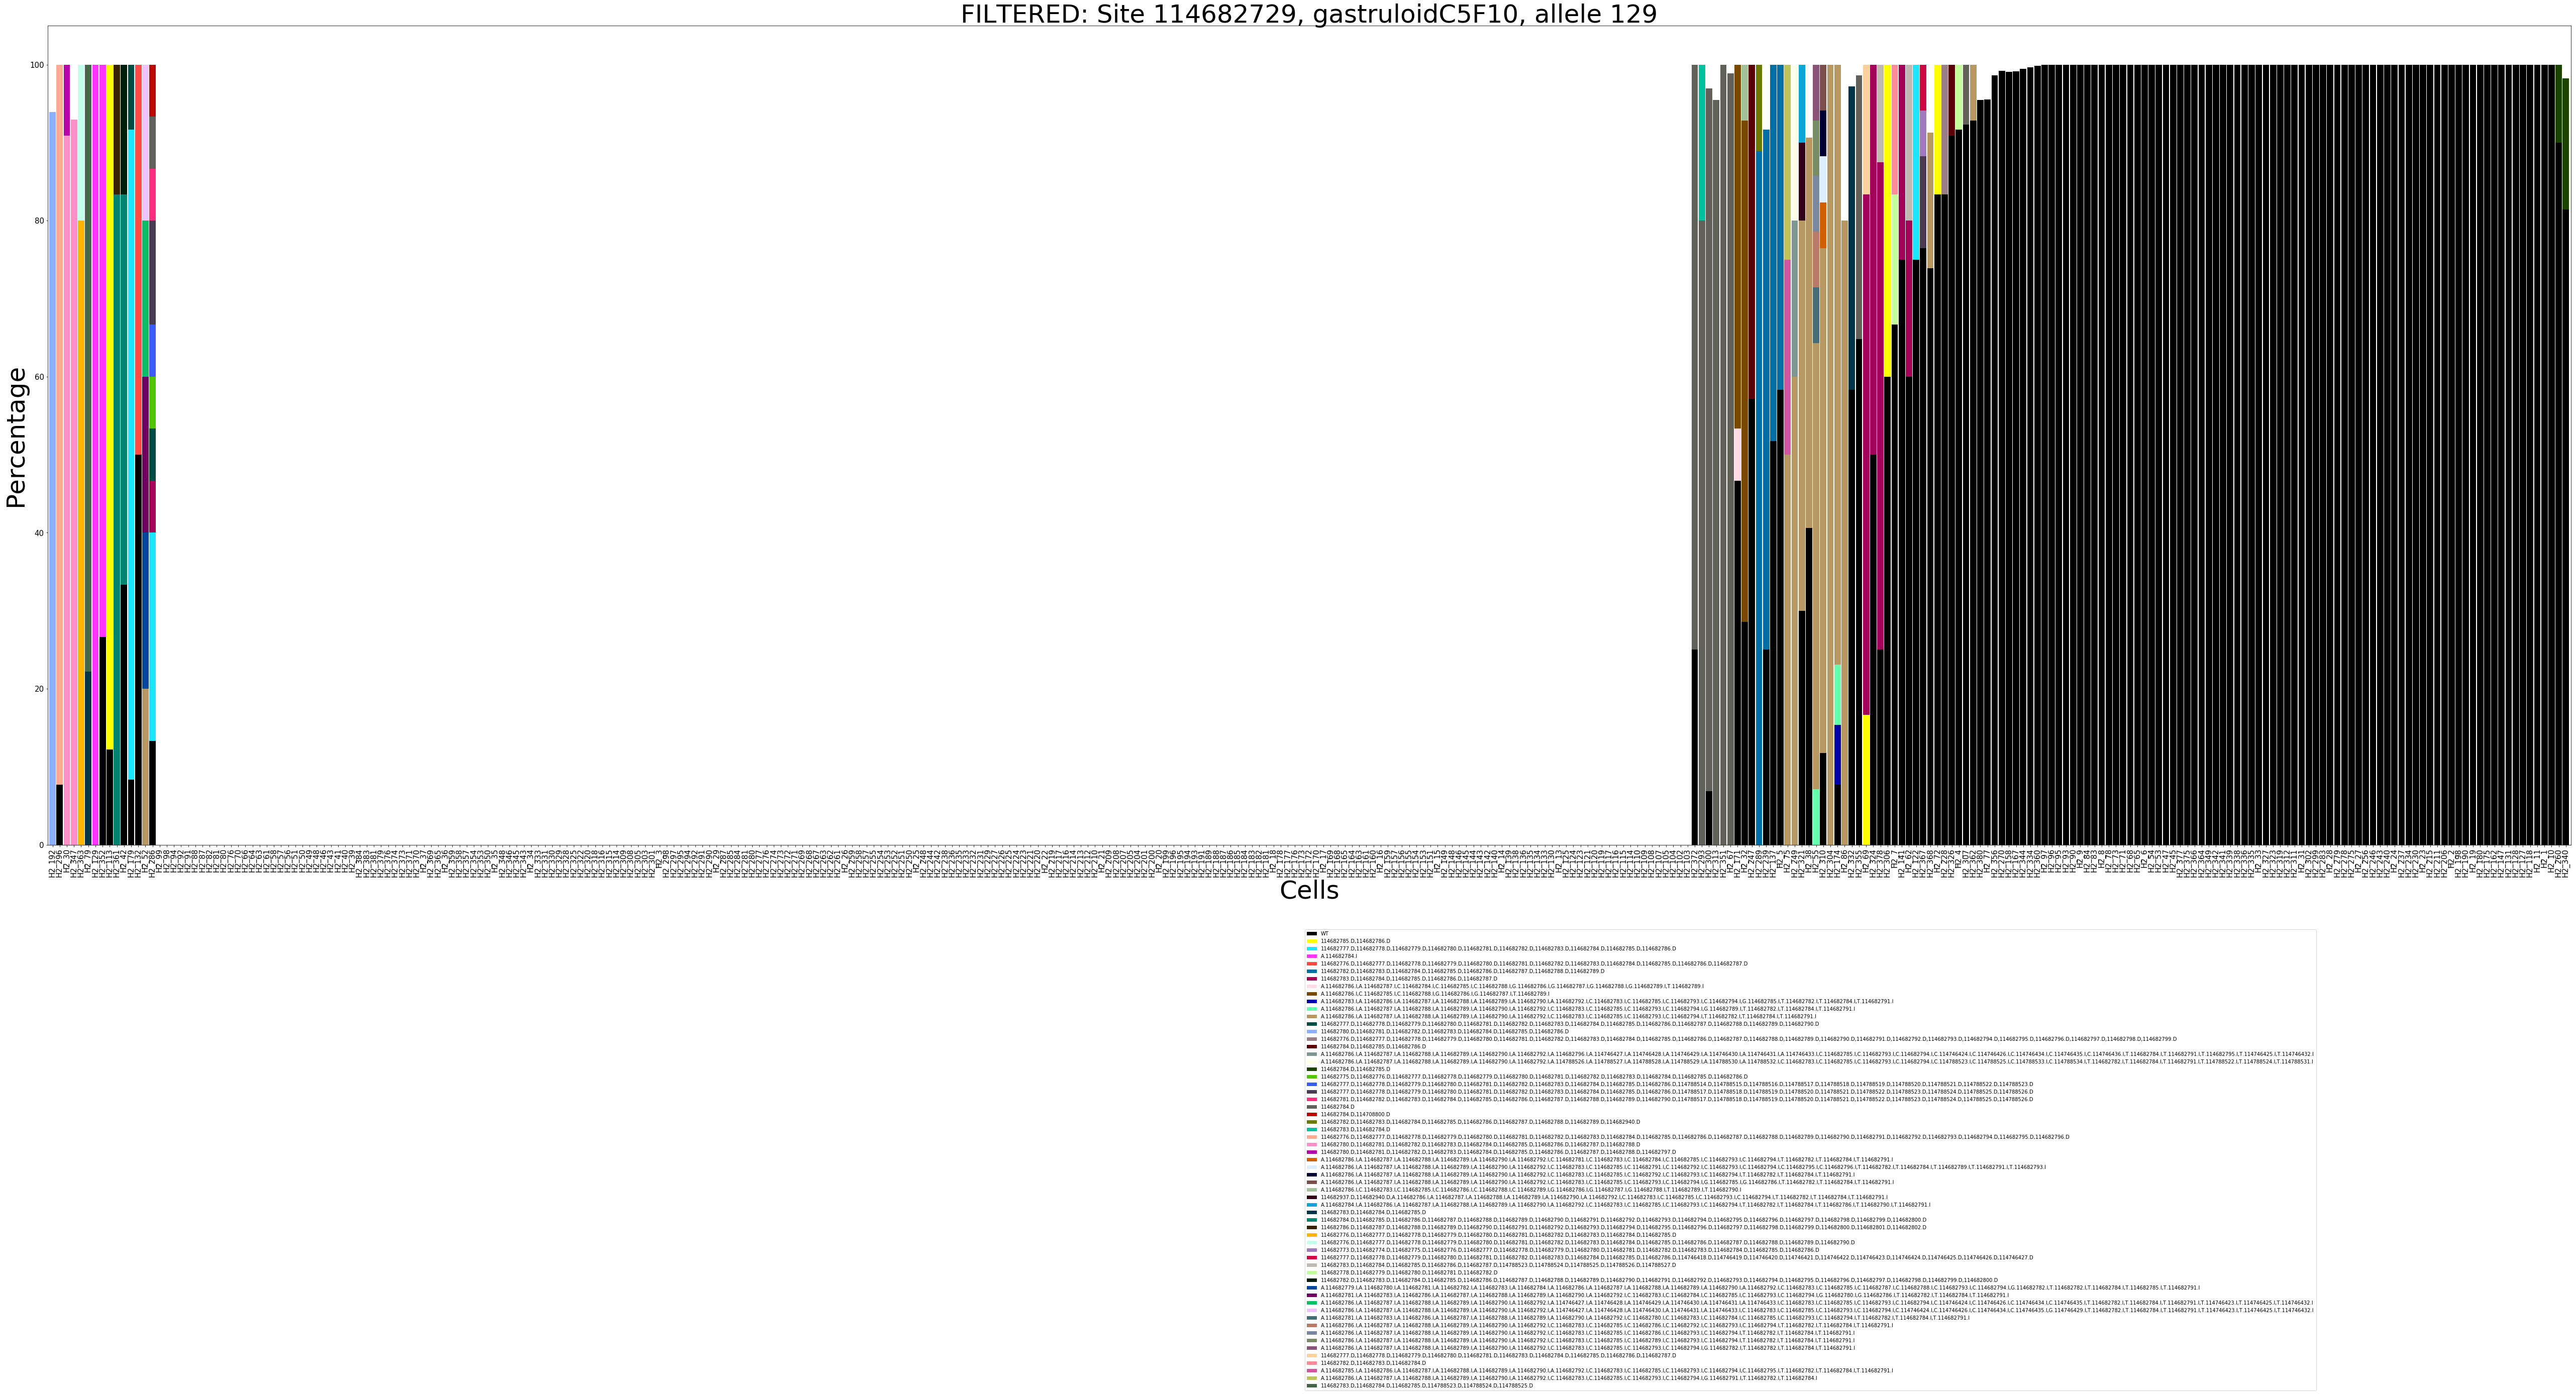

In [13]:
plotPercentagesAllele129('C5F10',114682729)

# Plotting allele counts

Plot allele counts of scars per cell for one site and all cells of one gastruloid

In [14]:
def plotAlleleCounts129(gastruloid, site):
    allelespersite = []
    for cell in alleleCountsChr12_129PD[gastruloid]:
        allelespersite.append(alleleCountsChr12_129PD[gastruloid][cell][site].dropna())
    
    allelespersitepd = pd.DataFrame(allelespersite)
    order = scipy.cluster.hierarchy.leaves_list(scipy.cluster.hierarchy.linkage(allelespersitepd.fillna(0)))
    orderedallelepersitepd = allelespersitepd.iloc[order]
    ax = orderedallelepersitepd.plot.bar(stacked=True,figsize=(90,30),fontsize = 30,width=0.90, 
                                     color=cols)
    ax.set_xlabel("Cells",fontsize=80)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('FILTERED: Gastruloid ' + gastruloid +', site ' + str(site) + ', allele 129', fontsize=100)
    ax.set_ylabel("Allele count",fontsize=80)
    ax.legend(bbox_to_anchor=(1,-0.1))
    return ax

def plotAlleleCountsB6(gastruloid, site):
    allelespersite = []
    for cell in alleleCountsChr12_B6PD[gastruloid]:
        allelespersite.append(alleleCountsChr12_B6PD[gastruloid][cell][site].dropna())
    
    allelespersitepd = pd.DataFrame(allelespersite)
    order = scipy.cluster.hierarchy.leaves_list(scipy.cluster.hierarchy.linkage(allelespersitepd.fillna(0)))
    orderedallelepersitepd = allelespersitepd.iloc[order]
    ax = orderedallelepersitepd.plot.bar(stacked=True,figsize=(90,30),fontsize = 30,width=0.90, 
                                     color=cols)
    ax.set_xlabel("Cells",fontsize=80)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('FILTERED: Gastruloid ' + gastruloid +', site ' + str(site) + ', allele B6', fontsize=100)
    ax.set_ylabel("Allele count",fontsize=80)
    ax.legend(bbox_to_anchor=(1,-0.1))
    return ax

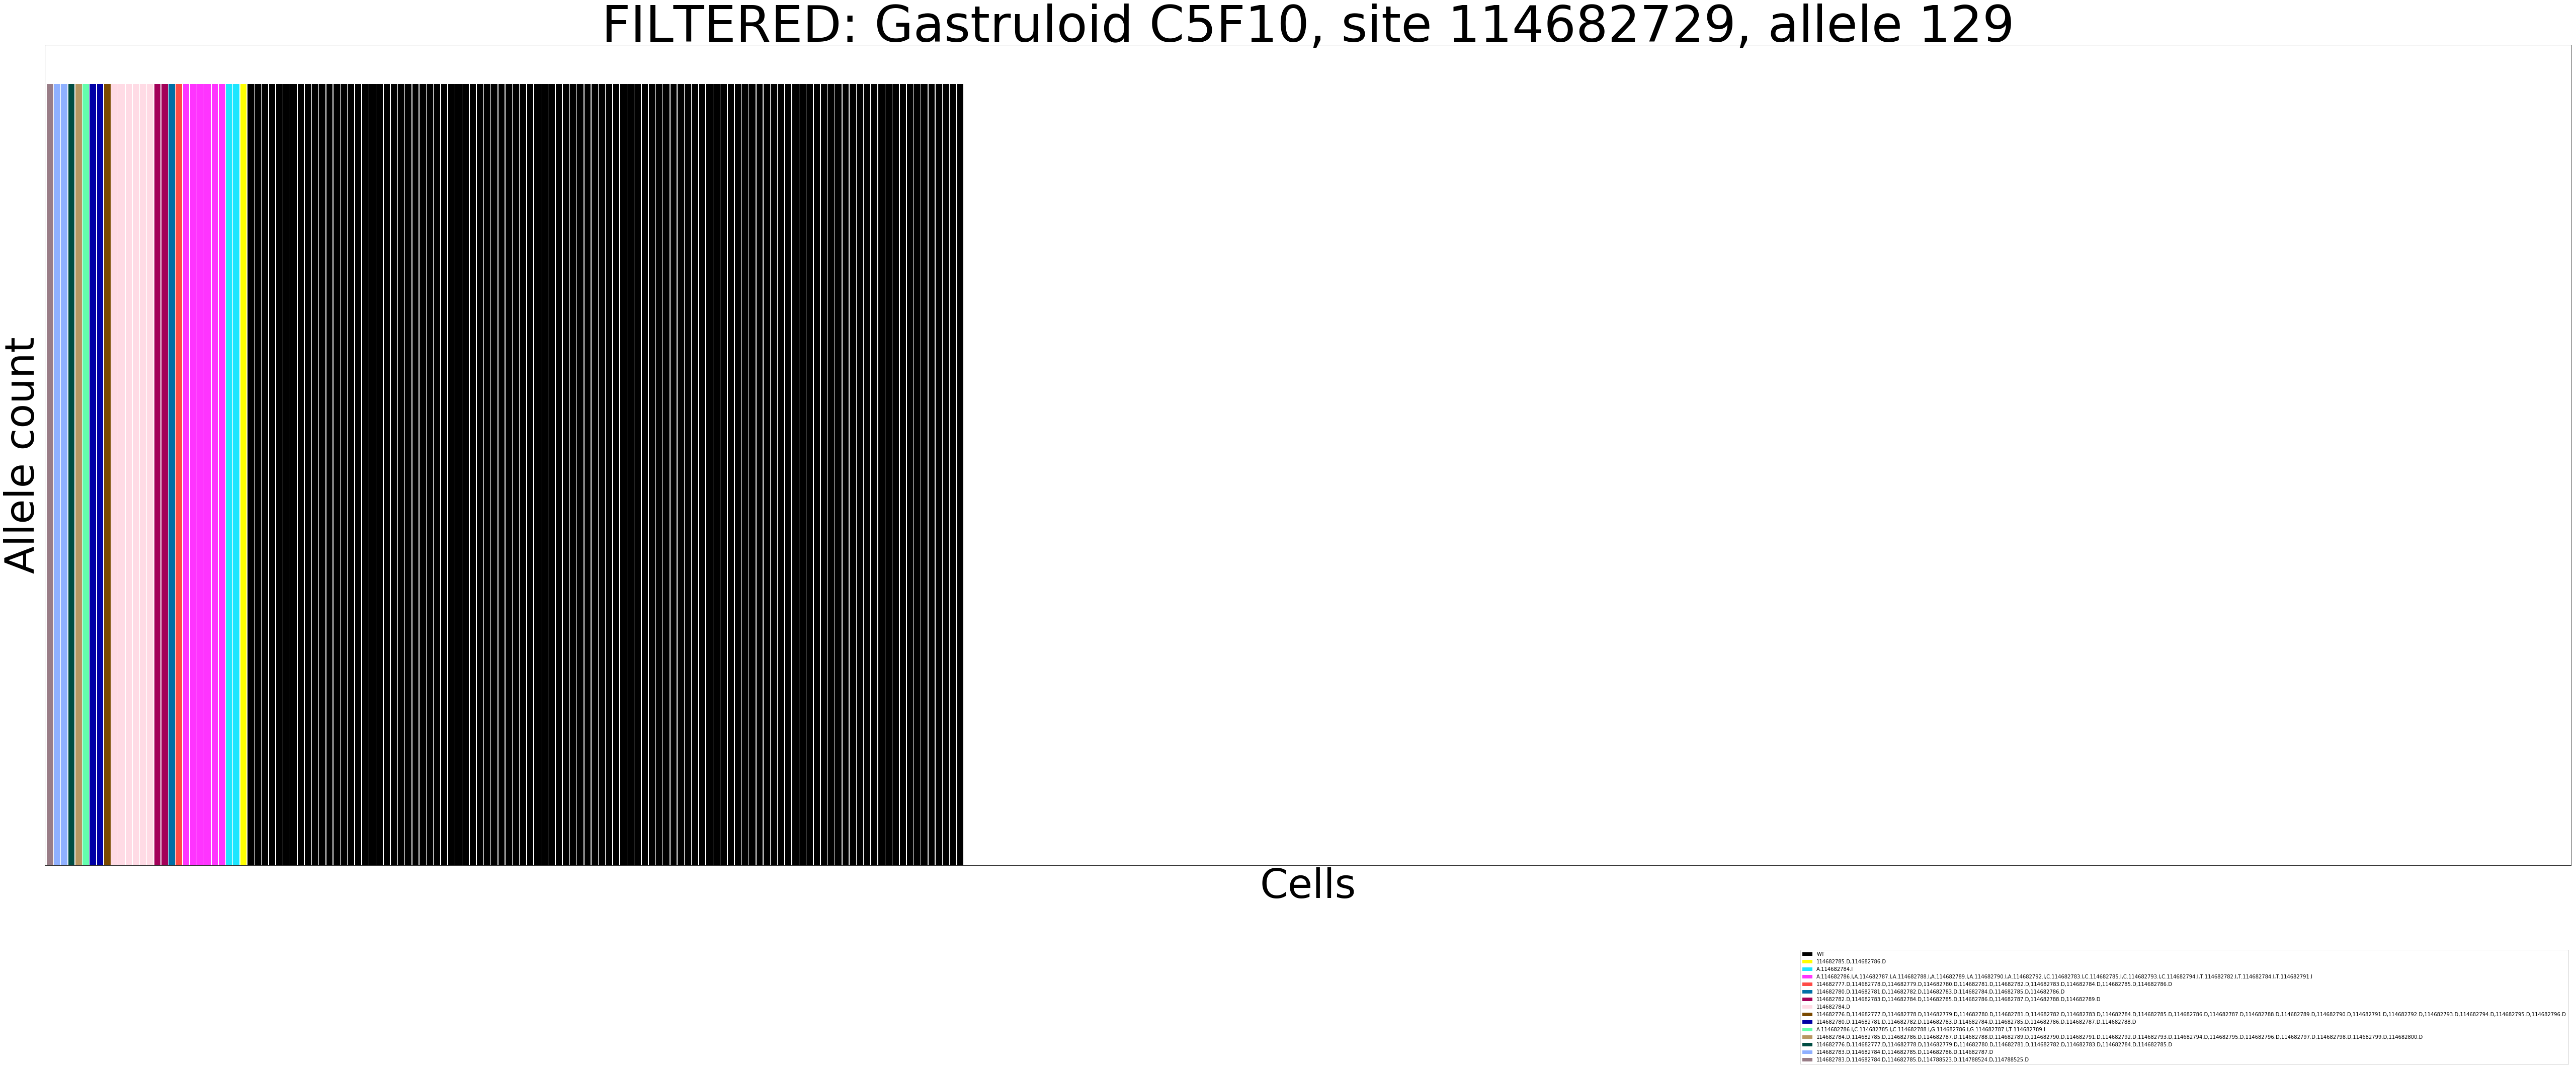

In [15]:
plotAlleleCounts129('C5F10',114682729)

# 'heatmap' plot - to plot all scars for all sites 

#### We can do an unsupervised selection of sites with high coverage

In [16]:
alleleCounts_all = collections.defaultdict(dict)
for (gastruloid,cell),allSitesInHeatmap in heatmap.T.items():
    for (alleleSite,scar) in allSitesInHeatmap.items():
        if pd.isnull(scar) == False:
            alleleCounts_all[alleleSite][(gastruloid,cell)] = 1

            
alleleCounts_all = pd.DataFrame(alleleCounts_all)

Take top 20 most highly covered sites

In [17]:
list_highCoveredSites = pd.DataFrame(alleleCounts_all.sum().sort_values(ascending=False))
list_highCoveredSites[0:20]

0
B6, 114788470          2403.0
129, 114937210         2343.0
129, 114788470         2151.0
nonallelic, 114879985  1668.0
B6, 114740505          1513.0
nonallelic, 114896335  1372.0
129, 114708745         1364.0
129, 114746371         1308.0
129, 114682729         1281.0
nonallelic, 114851288  1098.0
129, 114817194         1060.0
nonallelic, 114925051   968.0
129, 114788530          966.0
nonallelic, 114740505   923.0
129, 114896335          710.0
129, 114804713          700.0
129, 114879985          603.0
129, 114672065          537.0
nonallelic, 114970152   495.0
129, 114740505          384.0

In [18]:
top20 = list_highCoveredSites.index[0:20]
top20

Index(['B6, 114788470', '129, 114937210', '129, 114788470',
       'nonallelic, 114879985', 'B6, 114740505', 'nonallelic, 114896335',
       '129, 114708745', '129, 114746371', '129, 114682729',
       'nonallelic, 114851288', '129, 114817194', 'nonallelic, 114925051',
       '129, 114788530', 'nonallelic, 114740505', '129, 114896335',
       '129, 114804713', '129, 114879985', '129, 114672065',
       'nonallelic, 114970152', '129, 114740505'],
      dtype='object')

In [19]:
df_targetsites = heatmap[top20]

#### Or we can select known scar sites

Theoretically, all sites:
1. 114682729
2. 114708745
3. 114723869
4. 114736342
5. 114740505
6. 114746370/114746371
7. 114788470
8. 114843748
9. 114851288
10. 114879985
11. 114896335
12. 114910169
13. 114914696

df_targetsites = heatmap[['129, 114682729', 'B6, 114682729', 'nonallelic, 114682729',
                          '129, 114708745', 'B6, 114708745', 'nonallelic, 114708745',
                          '129, 114723869', 'B6, 114723869', 'nonallelic, 114723869',
                          '129, 114736342', 'B6, 114736342', 'nonallelic, 114736342',
                          '129, 114740505', 'B6, 114740505', 'nonallelic, 114740505',
                          '129, 114746370', 'B6, 114746370', 'nonallelic, 114746370',
                          '129, 114788470', 'B6, 114788470', 'nonallelic, 114788470',
                          '129, 114843748', 'B6, 114843748', 'nonallelic, 114843748',
                          '129, 114851288', 'B6, 114851288', 'nonallelic, 114851288',
                          '129, 114879985', 'B6, 114879985', 'nonallelic, 114879985',
                          '129, 114896335', 'B6, 114896335', 'nonallelic, 114896335',
                         '129, 114910169', 'B6, 114910169', 'nonallelic, 114910169',
                         '129, 114914696', 'B6, 114914696', 'nonallelic, 114914696']]

In [20]:
targetsites = [114682729, 14708745, 114723869, 114740505,114746370, 114788469, 114843748, 114851287,
          114879985,114896335,114910108,114914696]

In [23]:
heatmap

129, 114708745  \
gastruloid cell                                                        
C5A9       A2_1                                                   WT   
           A2_10                                                  WT   
           A2_100                                                NaN   
           A2_101                                                NaN   
           A2_102                                                NaN   
...                                                              ...   
C5H9       E2_95                                                  WT   
           E2_96                                                  WT   
           E2_97                                                  WT   
           E2_98   114708799.D,114708800.D,114708801.D,114708802....   
           E2_99                                                  WT   

                  129, 114723869  \
gastruloid cell                    
C5A9       A2_1               WT   
           A2_10             NaN   
           A2_100            NaN   
           A2_101            NaN   
           A2_102            NaN   
...                          ...   
C5H9       E2_95             NaN   
           E2_96              WT   
           E2_97             NaN   
           E2_98             NaN   
           E2_99             NaN   

                                                      129, 114746371  \
gastruloid cell                                                        
C5A9       A2_1                                                   WT   
           A2_10                                                  WT   
           A2_100                                                NaN   
           A2_101                                                NaN   
           A2_102  114746424.D,114746425.D,114746426.D,114746427....   
...                                                              ...   
C5H9       E2_95   114746417.D,114746418.D,114746419.D,114746422....   
           E2_96                                                 NaN   
           E2_97                         G.114746427.I,G.114746428.I   
           E2_98   114746424.D,114746425.D,114746426.D,114746427....   
           E2_99                                                 NaN   

                                                      129, 114788470  \
gastruloid cell                                                        
C5A9       A2_1                                                   WT   
           A2_10   114788523.D,114788524.D,114788525.D,114788526....   
           A2_100                                        114788524.D   
           A2_101                114788524.D,114788525.D,114788526.D   
           A2_102  114788523.D,114788524.D,114788525.D,114788526....   
...                                                              ...   
C5H9       E2_95                                                 NaN   
           E2_96                                                 NaN   
           E2_97                                                 NaN   
           E2_98   114788523.D,114788524.D,114788525.D,114788526....   
           E2_99                                                  WT   

                  129, 114788530 129, 114804713 129, 114879985  \
gastruloid cell                                                  
C5A9       A2_1               WT             WT             WT   
           A2_10             NaN            NaN             WT   
           A2_100            NaN             WT            NaN   
           A2_101             WT            NaN            NaN   
           A2_102            NaN            NaN            NaN   
...                          ...            ...            ...   
C5H9       E2_95             NaN            NaN            NaN   
           E2_96             NaN             WT            NaN   
           E2_97              WT             WT            NaN   
           E2_98             NaN            NaN 

In [28]:
heatmap.filter(regex=r'7884')

129, 114788470  \
gastruloid cell                                                        
C5A9       A2_1                                                   WT   
           A2_10   114788523.D,114788524.D,114788525.D,114788526....   
           A2_100                                        114788524.D   
           A2_101                114788524.D,114788525.D,114788526.D   
           A2_102  114788523.D,114788524.D,114788525.D,114788526....   
...                                                              ...   
C5H9       E2_95                                                 NaN   
           E2_96                                                 NaN   
           E2_97                                                 NaN   
           E2_98   114788523.D,114788524.D,114788525.D,114788526....   
           E2_99                                                  WT   

                  129, 114788498  \
gastruloid cell                    
C5A9       A2_1              NaN   
           A2_10             NaN   
           A2_100            NaN   
           A2_101            NaN   
           A2_102            NaN   
...                          ...   
C5H9       E2_95             NaN   
           E2_96             NaN   
           E2_97             NaN   
           E2_98             NaN   
           E2_99             NaN   

                                                       B6, 114788470  \
gastruloid cell                                                        
C5A9       A2_1    114788523.D,114788524.D,114788525.D,114788526....   
           A2_10   114788523.D,114788524.D,114788525.D,114788526....   
           A2_100  114788523.D,114788524.D,114788525.D,114788526....   
           A2_101  114788523.D,114788524.D,114788525.D,114788526....   
           A2_102  114788523.D,114788524.D,114788525.D,114788526....   
...                                                              ...   
C5H9       E2_95   114788523.D,114788524.D,114788525.D,114788526....   
           E2_96   114788523.D,114788524.D,114788525.D,114788526....   
           E2_97   114788523.D,114788524.D,114788525.D,114788526....   
           E2_98   114788523.D,114788524.D,114788525.D,114788526....   
           E2_99   114788523.D,114788524.D,114788525.D,114788526....   

                  nonallelic, 114788470  
gastruloid cell                          
C5A9       A2_1                     NaN  
           A2_10                    NaN  
           A2_100                   NaN  
           A2_101                   NaN  
           A2_102                   NaN  
...                                 ...  
C5H9       E2_95                    NaN  
           E2_96                    NaN  
           E2_97                    NaN  
           E2_98                    NaN  
           E2_99                    NaN  

[2938 rows x 4 columns]

In [29]:
df_targetsites = heatmap[['129, 114682729',
                          '129, 114708745', 'B6, 114708745', 
                          '129, 114723869', 'B6, 114723869', 
                         'B6, 114740505',
                          '129, 114788470', 'B6, 114788470',
                          '129, 114879985',
                          '129, 114896335']] 

Some quality checks

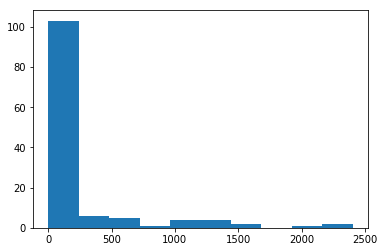

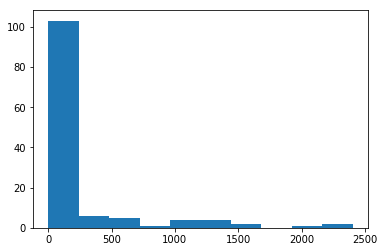

In [30]:
# Select sites with plenty of data:
plt.hist( (~pd.isnull(heatmap)).sum() )
plt.show()
df_selected = heatmap.loc[:, ((~pd.isnull(heatmap)).sum()>150) ]
plt.hist( (~pd.isnull(heatmap)).sum() )
plt.show()


In [31]:
## For the full dataset, not separated for each gastruloid yet
# define the total amount of scars
totalScars = set()
for i,r in df_targetsites.iterrows():
    totalScars.update( set( [x for x in r.unique() if not pd.isnull(x)]) )


In [32]:
## For the full dataset, not separated for each gastruloid yet
# define one colour for each scar
cmap = plt.get_cmap('hsv')
scarColors = { scar: cmap(x) for scar, x in zip(totalScars, np.linspace(0,1, len(totalScars))) }
scarColors['WT'] = (0,0,0)

In [33]:
# Determine organisation of the plot, based on site-allele with most information
df_targetsites = df_targetsites.sort_values([df_targetsites.columns[0],df_targetsites.columns[1]])


In [34]:
df_targetsites = df_targetsites[(~pd.isnull(df_targetsites)).sum(axis=1)>0]


### Rows are cells and columns are sites-alleles. Plots are made for the full dataset or for each gastruloid separately.

In [35]:
def plotHeatmap(df, figsize = (15,50)):
    fig, ax = plt.subplots(1, figsize=figsize)
    columnsCount = df.shape[1]
    
    rowHeight = 1
    rowColwidth = 1
    rowSpacing = 0.3
    for cellIndex, (cellName, row) in enumerate(df.iterrows()):
        for columnIndex,column in enumerate(df.columns):
            scarForThisCell = row[column]
            if not pd.isnull(scarForThisCell):
                ax.add_patch(
                matplotlib.patches.Rectangle(
                    (rowColwidth*columnIndex,rowHeight*cellIndex ), 
                    rowColwidth, rowHeight-rowSpacing, color= scarColors[scarForThisCell])
            )

    ax.set_ylim(0,rowHeight*(df.shape[0]+1))
    ax.set_xlim(0,rowColwidth*(df.shape[1]))
    ax.set_xticks([columnIndex+0.5 for columnIndex,column in enumerate(df.columns)])
    ax.set_xticklabels([column for columnIndex,column in enumerate(df.columns)],rotation=90)
    ax.set_yticks([cellIndex+0.5 for cellIndex,cellName in enumerate(df.index)])
    ax.set_yticklabels([cellName for cellIndex,cellName in enumerate(df.index)],fontsize=6.5)

    return ax

To plot all sites, all gastruloids:

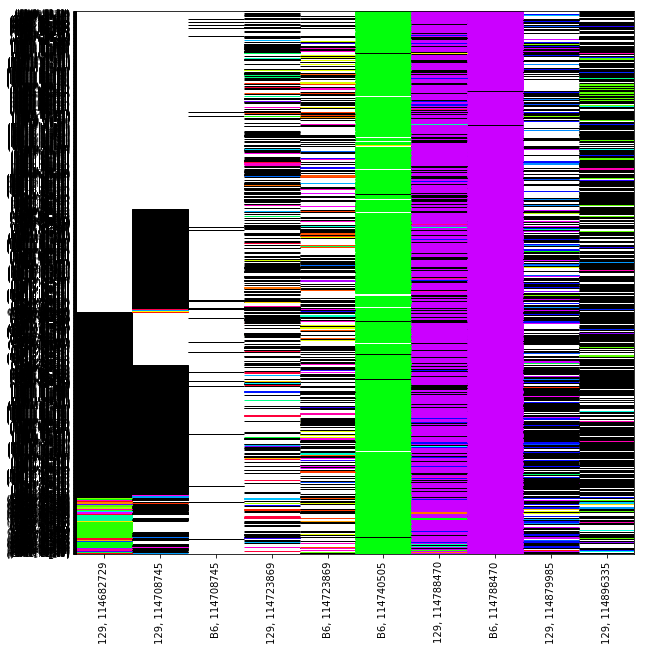

In [36]:
plotHeatmap(df_targetsites, (10,10))

Plotting heatmaps for individual gastruloids:

In [37]:
# to check which gastruloids are present in the dataset
heatmap.index.levels[0]

Index(['C5A9', 'C5B10', 'C5C6', 'C5F10', 'C5G7', 'C5H11', 'C5H7', 'C5H9'], dtype='object', name='gastruloid')

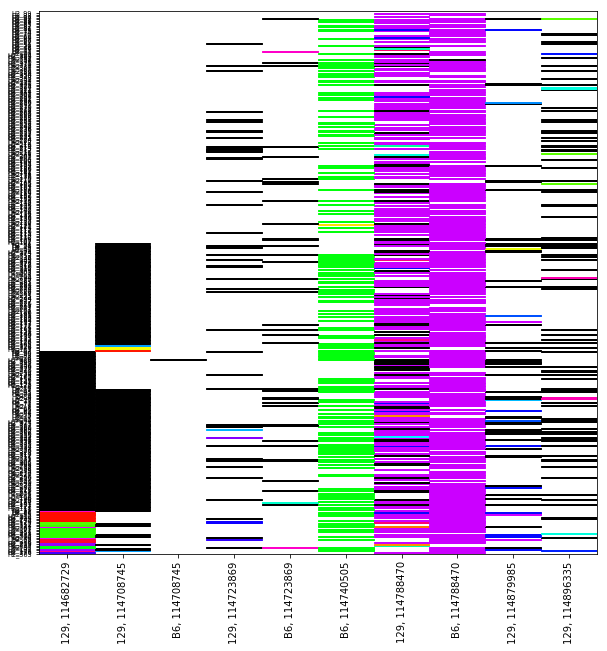

In [38]:
plotHeatmap(df_targetsites.loc['C5F10'], (10,10))

# Clustering using Information Weighted Sparse Sample Distance (IWSS)

In [39]:
all_allelecounts_fordistancecalc.columns.levels[0]

Index(['C5A9', 'C5B10', 'C5C6', 'C5F10', 'C5G7', 'C5H11', 'C5H7', 'C5H9'], dtype='object')

In [40]:
all_allelecounts = all_allelecounts_fordistancecalc.fillna(0).transpose()
# to check scars only, no WT counts
all_allelecounts_noWT = all_allelecounts[all_allelecounts.columns.drop(list(all_allelecounts.filter(regex='WT')))]

In [41]:
def plotAllAlleleCounts(allelecounts, bins=20,color='black'):
    plt.figure(figsize=(8,4))
    allelecounts.sum(axis=1).plot.hist(grid=True, bins=bins, rwidth=0.95,color=color)
    plt.xlabel('Amount of counts per cell')
    plt.title('Amount of counts per cell')
    plt.ylabel('Number of cells')

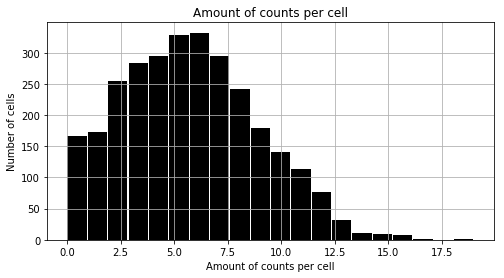

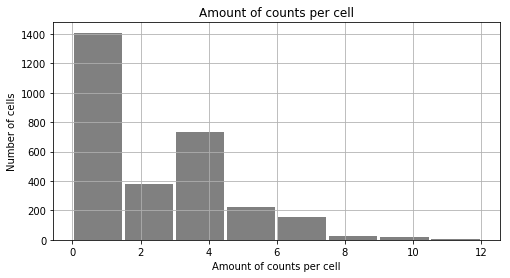

In [42]:
plotAllAlleleCounts(all_allelecounts)
plotAllAlleleCounts(all_allelecounts_noWT, bins=8,color='grey')

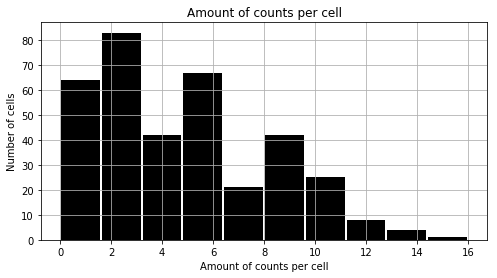

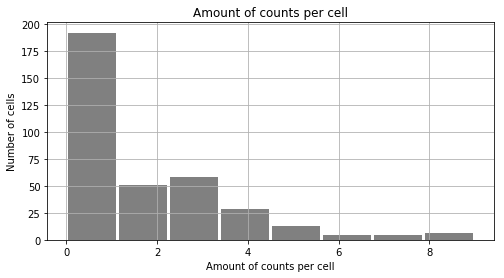

In [43]:
plotAllAlleleCounts(all_allelecounts.loc['C5F10'], bins = 10)
plotAllAlleleCounts(all_allelecounts_noWT.loc['C5F10'], bins=8,color='grey')

In [44]:
#this filters out cells with less than n counts
filtered_all_allelecounts = collections.defaultdict(dict)
for cell in all_allelecounts.index:
    if all_allelecounts.loc[cell].sum() > 2:
        filtered_all_allelecounts[cell] = all_allelecounts.loc[cell]
filtered_all_allelecountsPD = pd.DataFrame.from_dict(filtered_all_allelecounts).transpose()

filter_allelecountsC5A9 = filtered_all_allelecountsPD.loc['C5A9'].fillna(0)
filter_allelecountsC5B10 = filtered_all_allelecountsPD.loc['C5B10'].fillna(0)
filter_allelecountsC5C6 = filtered_all_allelecountsPD.loc['C5C6'].fillna(0)
filter_allelecountsC5F10 = filtered_all_allelecountsPD.loc['C5F10'].fillna(0)
filter_allelecountsC5G7 = filtered_all_allelecountsPD.loc['C5G7'].fillna(0)
filter_allelecountsC5H11 = filtered_all_allelecountsPD.loc['C5H11'].fillna(0)
filter_allelecountsC5H7 = filtered_all_allelecountsPD.loc['C5H7'].fillna(0)
filter_allelecountsC5H9 = filtered_all_allelecountsPD.loc['C5H9'].fillna(0)
filter_all_allelecounts = filtered_all_allelecountsPD.fillna(0).transpose()

# Distance matrix for all gastruloids

distanceMatrix automatically returns the figure of the clustering. In addition, when saying x = distanceMatrix(dataframe), it assigns the output (distance) matrix df to x. This can later be used for clustering the data into groups.

In [45]:
def distanceMatrix(filteredDF,figsize=(15,15),heatmapTitle=''):
    rawMatrix = filteredDF.values 
    rawMatrix = rawMatrix[:, np.logical_and( 
        np.sum(rawMatrix==0,axis=0)>0,
        np.sum(rawMatrix==1,axis=0)>0)]
    pOnes = []
    pZeros = []
    for i in range(rawMatrix.shape[1]):
    # Weights:
        column = rawMatrix[:,i]
        pOnes.append( -np.log2( ( np.sum(column==1)/len(column) )**2 ) ) #probability of two cells both having sSNV
        pZeros.append( -np.log2( ( np.sum(column==0)/len(column) )**2 ) )#probability of two cells not having sSNV,  (and we know it)
    pOnes = np.array(pOnes)
    pZeros = np.array(pZeros)
    
    print( np.sum( np.logical_not(np.isfinite(pZeros)) ),  np.sum((np.isfinite(pZeros))))
    print( np.sum( np.logical_not(np.isfinite(pOnes)) ),  np.sum((np.isfinite(pOnes))))
    print(rawMatrix.shape)
    
    jointMatrix = np.zeros( (rawMatrix.shape[0], rawMatrix.shape[0]) )
    simMatrix =  np.zeros( (rawMatrix.shape[0], rawMatrix.shape[0]) )
    differenceMatrix =  np.zeros( (rawMatrix.shape[0], rawMatrix.shape[0]) )

    for cai in range(rawMatrix.shape[0]):
        for cbi in range(rawMatrix.shape[0]):
            
        
                # Un normalized distance
            pairwiseUnnormalizedDistance = np.logical_and( rawMatrix[cai,:]==1, rawMatrix[cbi,:]==0 ) * \
            (pOnes + pZeros) + \
            np.logical_and( rawMatrix[cai,:]==0, rawMatrix[cbi,:]==1 ) * (pZeros + pOnes) # For different batches the pOnes/pZeros is batch depended

                # Normalize the distance:
            normalisationFactor = np.sum( pOnes* (rawMatrix[cai,:]==1)) + np.sum( pZeros*(rawMatrix[cai,:]==0)) + \
            np.sum( pOnes* (rawMatrix[cbi,:]==1)) + np.sum( pZeros* (rawMatrix[cbi,:]==0))

            pairwiseNormalizedDistance = np.sum(pairwiseUnnormalizedDistance) / (
                        normalisationFactor )
            differenceMatrix[cai, cbi] = pairwiseNormalizedDistance

                # Similarity calculation:
            sim = np.sum( (pOnes+pOnes) * np.logical_and( rawMatrix[cai,:]==1, rawMatrix[cbi,:]==1 )) + \
                      np.sum( (pZeros+pZeros)*np.logical_and( rawMatrix[cai,:]==0, rawMatrix[cbi,:]==0 ))

            normalisedSim = sim/normalisationFactor
            simMatrix[cai, cbi] = normalisedSim

            joinedDistance =  pairwiseNormalizedDistance + (1-normalisedSim )
            jointMatrix[cai,cbi]= joinedDistance


            if cai==cbi:
                break

    normalisedSim, normalisationFactor, sim, rawMatrix[cai,rawMatrix[cai,:]>=0], rawMatrix[cbi,rawMatrix[cbi,:]>=0]
    print(np.where( np.logical_not( np.isfinite( jointMatrix ) ) ))
    #rawMatrix[ np.where( np.logical_not( np.isfinite( jointMatrix ) ) )[0][0] ]
    
    for i in range(jointMatrix.shape[0]):
        for j in range(jointMatrix.shape[0]):
            jointMatrix[j,i]=jointMatrix[i,j]
            if i==j:
                break

    df = pd.DataFrame( np.log(jointMatrix+1), index=filteredDF.index, columns=filteredDF.index )
    x = sns.clustermap( df, vmin=0,vmax=1, figsize=figsize, method='average',metric='euclidean')
    x.fig.suptitle(heatmapTitle)
    x.fig.subplots_adjust(top=0.93)
    #.savefig('heatmapC5F10.png',dpi=300)
    return df
    



## All gastruloids from dataset
 'C5A9', 'C5B10', 'C5C6', 'C5F10',  C5G7', 'C5H11', 'C5H7', 'C5H9'

0 63
0 63
(215, 63)
(array([], dtype=int64), array([], dtype=int64))


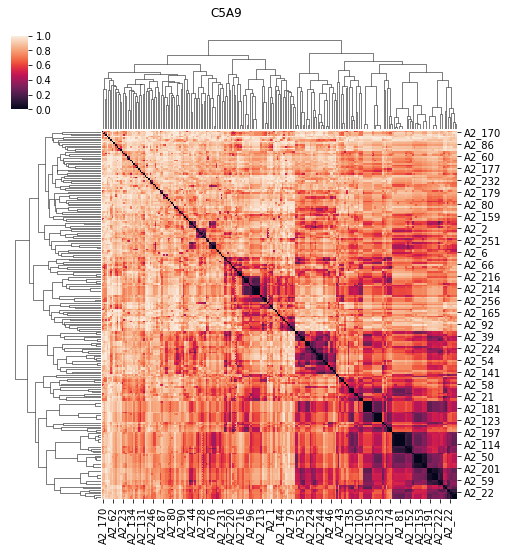

In [46]:
dmC5A9 = distanceMatrix(filter_allelecountsC5A9, figsize = (8,8), heatmapTitle='C5A9')

0 70
0 70
(257, 70)
(array([], dtype=int64), array([], dtype=int64))


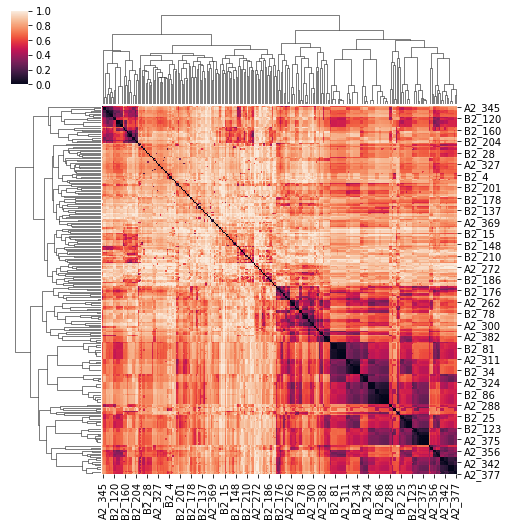

In [47]:
dmC5B10 = distanceMatrix(filter_allelecountsC5B10, figsize = (8,8))

0 91
0 91
(254, 91)
(array([], dtype=int64), array([], dtype=int64))


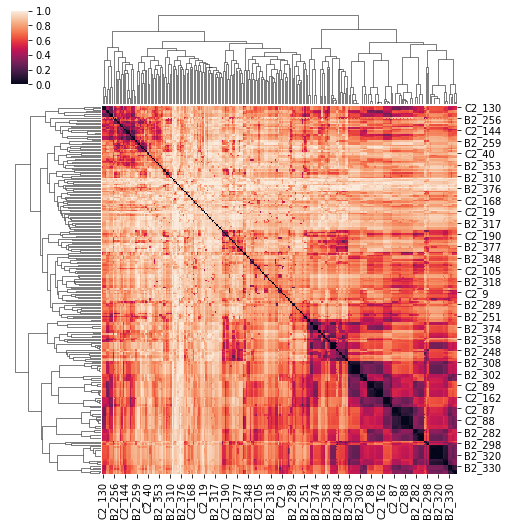

In [48]:
dmC5C6 = distanceMatrix(filter_allelecountsC5C6, figsize = (8,8))

0 73
0 73
(249, 73)
(array([], dtype=int64), array([], dtype=int64))


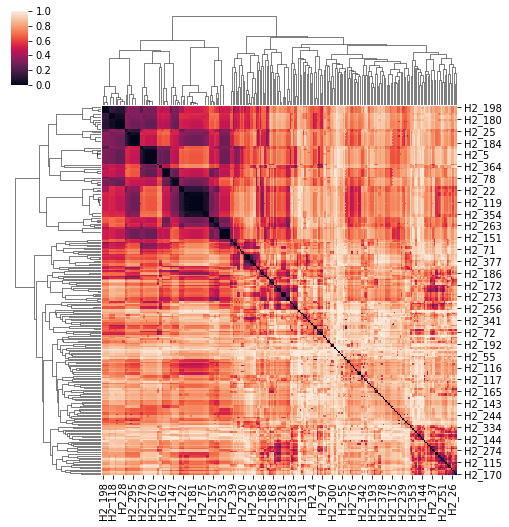

In [49]:
dmC5F10 = distanceMatrix(filter_allelecountsC5F10, figsize = (8,8))

0 115
0 115
(398, 115)
(array([], dtype=int64), array([], dtype=int64))


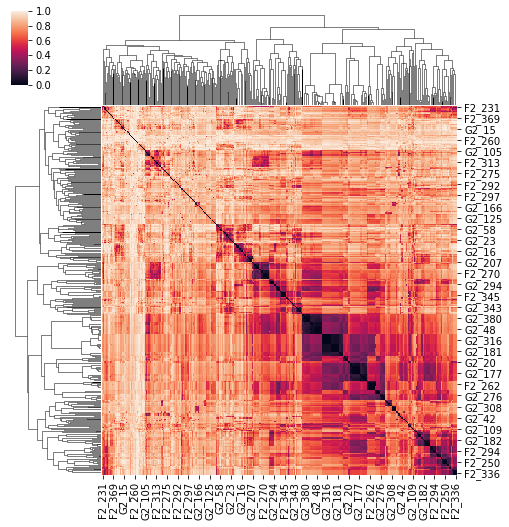

In [50]:
dmC5G7 = distanceMatrix(filter_allelecountsC5G7, figsize = (8,8))

0 93
0 93
(396, 93)
(array([], dtype=int64), array([], dtype=int64))


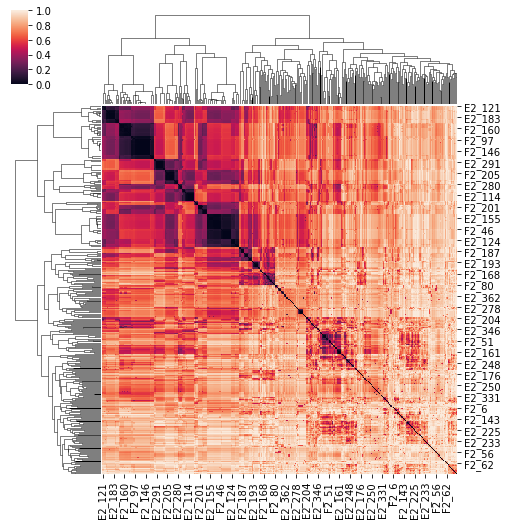

In [51]:
dmC5H11 = distanceMatrix(filter_allelecountsC5H11, figsize = (8,8))

0 83
0 83
(298, 83)
(array([], dtype=int64), array([], dtype=int64))


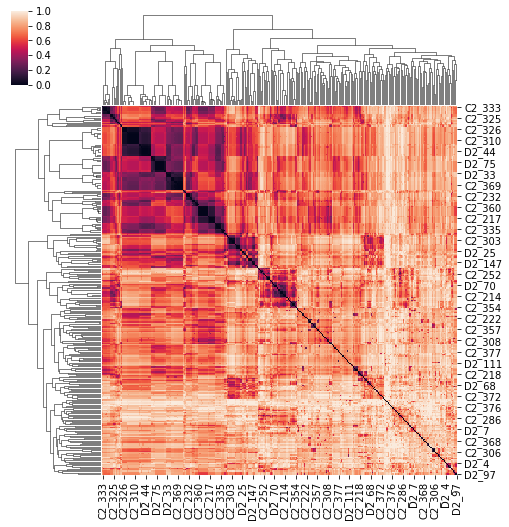

In [52]:
dmC5H7 = distanceMatrix(filter_allelecountsC5H7, figsize = (8,8))

0 80
0 80
(277, 80)
(array([], dtype=int64), array([], dtype=int64))


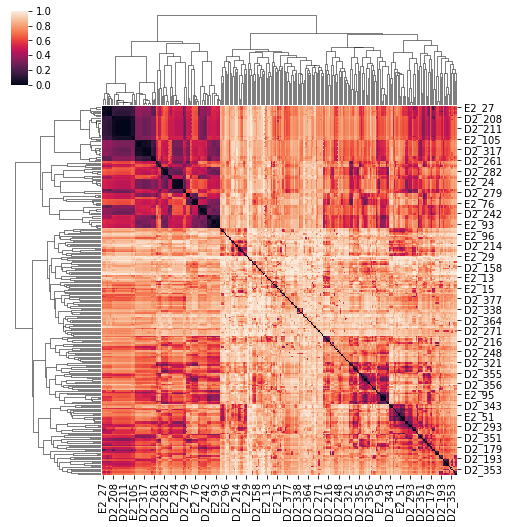

In [53]:
dmC5H9 = distanceMatrix(filter_allelecountsC5H9, figsize = (8,8))

In [54]:
all_allelecounts_fordistancecalc.columns.levels[0]

Index(['C5A9', 'C5B10', 'C5C6', 'C5F10', 'C5G7', 'C5H11', 'C5H7', 'C5H9'], dtype='object')

## Clustering based on computed distance matrix.

In [55]:
def scipyClustering(df, gastruloidName = '', clusterNumber = 20):
    x = scipy.cluster.hierarchy.linkage(df.fillna(0),'ward')
    clusters = scipy.cluster.hierarchy.cut_tree(x, n_clusters= (clusterNumber))
    clust = pd.DataFrame.from_dict({cellName:{('clust_' + gastruloidName):clusters[cellIndex][0]} for cellIndex,cellName in enumerate(df.index)}).transpose()
    return clust

In [56]:
C5F10_clust = scipyClustering(dmC5F10, gastruloidName = 'C5F10',  clusterNumber = (len(dmC5F10)/10))

In [57]:
C5A9_clust = scipyClustering(dmC5A9, gastruloidName = 'C5A9',  clusterNumber = (len(dmC5A9)/10))

In [58]:
C5B10_clust = scipyClustering(dmC5B10, gastruloidName = 'C5B10',  clusterNumber = (len(dmC5B10)/10))

In [59]:
C5C6_clust = scipyClustering(dmC5C6, gastruloidName = 'C5C6',  clusterNumber = (len(dmC5C6)/10))

In [60]:
C5G7_clust = scipyClustering(dmC5G7, gastruloidName = 'C5G7',  clusterNumber = (len(dmC5G7)/10))

In [61]:
C5H11_clust = scipyClustering(dmC5H11, gastruloidName = 'C5H11',  clusterNumber = (len(dmC5H11)/10))

In [62]:
C5H7_clust = scipyClustering(dmC5H7, gastruloidName = 'C5H7',  clusterNumber = (len(dmC5H7)/10))

In [63]:
C5H9_clust = scipyClustering(dmC5H9, gastruloidName = 'C5H9',  clusterNumber = (len(dmC5H9)/10))

# For tsne plots

In [65]:
tsne = read_csv('/Users/m.blotenburg/Documents/github/transcriptome/transcriptome_Datasets/tsneSTARmapped.txt', sep = '\t')
tsne.head()

V1        V2  scs.cpart
A1_196.C5F2  -3.627620  4.560004          1
A1_274.C5F2  -5.034636  3.246327          1
A1_107.C5C3  -3.793044  6.277366          1
A1_113.C5C3 -10.339905 -6.336527          2
A1_55.C5C3   11.032002 -7.177023          3

In [66]:
# format tsne dataframe
tsne2 = tsne.copy()
tsne2.index = tsne2.index.str.split('.', 1, expand=True)
tsne2 = tsne2.reset_index(level=1)
tsne2 = tsne2.rename(index=str, columns={"level_1": "gastruloid"})
tsne2.head()

gastruloid         V1        V2  scs.cpart
A1_196       C5F2  -3.627620  4.560004          1
A1_274       C5F2  -5.034636  3.246327          1
A1_107       C5C3  -3.793044  6.277366          1
A1_113       C5C3 -10.339905 -6.336527          2
A1_55        C5C3  11.032002 -7.177023          3

In [67]:
# add cluster information to tsne dataframe
dfs_all = [tsne2,C5F10_clust,C5A9_clust,C5B10_clust,C5C6_clust,C5G7_clust,C5H11_clust,C5H7_clust,C5H9_clust]
tsne_clust = dfs_all[0].join(dfs_all[1:],how='outer')
tsne_clust.tail()

gastruloid  V1  V2  scs.cpart  clust_C5F10  clust_C5A9  clust_C5B10  \
E2_7         NaN NaN NaN        NaN          NaN         NaN          NaN   
E2_77        NaN NaN NaN        NaN          NaN         NaN          NaN   
E2_81        NaN NaN NaN        NaN          NaN         NaN          NaN   
E2_87        NaN NaN NaN        NaN          NaN         NaN          NaN   
E2_99        NaN NaN NaN        NaN          NaN         NaN          NaN   

       clust_C5C6  clust_C5G7  clust_C5H11  clust_C5H7  clust_C5H9  
E2_7          NaN         NaN          NaN         NaN         0.0  
E2_77         NaN         NaN          NaN         NaN        12.0  
E2_81         NaN         NaN          NaN         NaN        14.0  
E2_87         NaN         NaN          NaN         NaN        15.0  
E2_99         NaN         NaN          NaN         NaN        21.0

In [ ]:
# save tsne with scar cluster information
tsne_clust.to_csv(pathToData + 'tsneSTARmapped_FilteredScarClusterInformation.csv')

In [68]:
# print number of clusters for each gastruloid
print('Number of clusters for C5F10: ' + str(tsne_clust['clust_C5F10'].max()))
print('Number of clusters for C5A9: ' + str(tsne_clust['clust_C5A9'].max()))
print('Number of clusters for C5B10: ' + str(tsne_clust['clust_C5B10'].max()))
print('Number of clusters for C5C6: ' + str(tsne_clust['clust_C5C6'].max()))
print('Number of clusters for C5G7: ' + str(tsne_clust['clust_C5G7'].max()))
print('Number of clusters for C5H11: ' + str(tsne_clust['clust_C5H11'].max()))
print('Number of clusters for C5H7: ' + str(tsne_clust['clust_C5H7'].max()))
print('Number of clusters for C5H9: ' + str(tsne_clust['clust_C5H9'].max()))

Number of clusters for C5F10: 24.0
Number of clusters for C5A9: 21.0
Number of clusters for C5B10: 25.0
Number of clusters for C5C6: 25.0
Number of clusters for C5G7: 39.0
Number of clusters for C5H11: 39.0
Number of clusters for C5H7: 29.0
Number of clusters for C5H9: 27.0


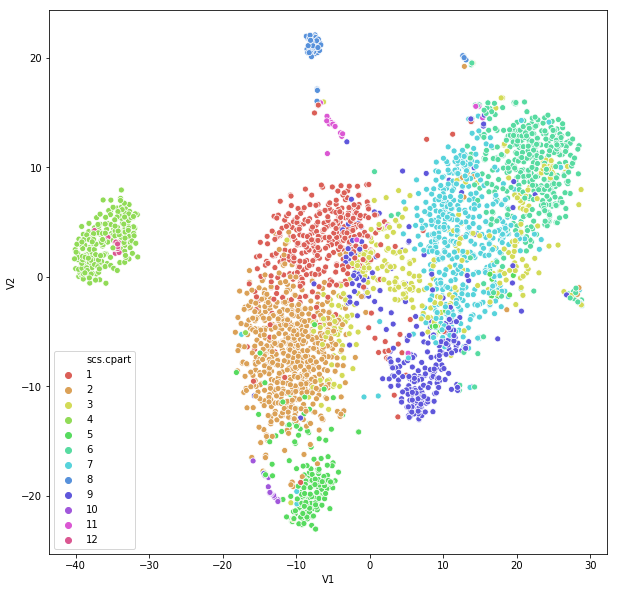

In [69]:
##### tsne with colours from raceid clusters
plt.figure(figsize=(10,10))
fig = sns.scatterplot(tsne['V1'], tsne['V2'], hue = tsne['scs.cpart'], palette=sns.color_palette("hls", 12))
#fig.figure.savefig(pathToSaveData + 'tsne_raceidClusters.png',dpi=300)

## Some definitions for easier plotting

In [71]:
def plotAllScarsonTranscriptomeMap(gastruloid,clusters, tsne_clust = tsne_clust):
    plt.figure(figsize=(10,10))
    fig = plt.scatter(tsne_clust['V1'], tsne_clust['V2'],c='lightgrey',edgecolor = 'grey', zorder=10)
    fig = plt.scatter(tsne_clust[tsne_clust['gastruloid'] == gastruloid]['V1'], 
            tsne_clust[tsne_clust['gastruloid'] == gastruloid]['V2'], c = [(0,0,0)],zorder=10,edgecolor = 'grey')
    fig = sns.scatterplot(tsne_clust['V1'], tsne_clust['V2'], hue = tsne_clust[clusters], marker = '*',
                palette='rainbow',legend=False, edgecolor = 'black', s=140, linewidth=0.2, zorder=10)
    plt.title(('All scar clusters for gastruloid ' + str(gastruloid)),fontsize=20)
#fig.figure.savefig(pathToSaveData + 'tsne_clusters/C5F10_TsneAllScars.png', dpi=300)
    
    

In [76]:
def plotPerClusteronTranscriptomeMap(gastruloid, clusters, tsne_clust = tsne_clust):
    for clustnr in tsne_clust[clusters].unique():
        if pd.isna(clustnr):
            continue
        plt.figure(figsize=(10,10))
        fig = plt.scatter(tsne_clust['V1'], tsne_clust['V2'],c='lightgrey',edgecolor = 'grey', zorder=10)
        fig = plt.scatter(tsne_clust[tsne_clust['gastruloid'] == gastruloid]['V1'], 
                tsne_clust[tsne_clust['gastruloid'] == gastruloid]['V2'],
                c = [(0,0,0)],zorder=10,edgecolor = 'grey')
        fig = plt.scatter(tsne_clust[tsne_clust[clusters] == clustnr]['V1'], 
                tsne_clust[tsne_clust[clusters] == clustnr]['V2'],
                c = [(1,0,0)], s = 125, marker = '*',zorder=10, edgecolor = 'maroon')
        plt.title('Gastruloid ' + str(gastruloid) + ', cluster ' + str(clustnr),fontsize=20)
        #fig.figure.savefig(pathToSaveData + 'tsne_clusters/C5F10_tsneCluster'+ str(clustnr) + '.png', dpi=300)
        plt.show()
    

### For C5F10

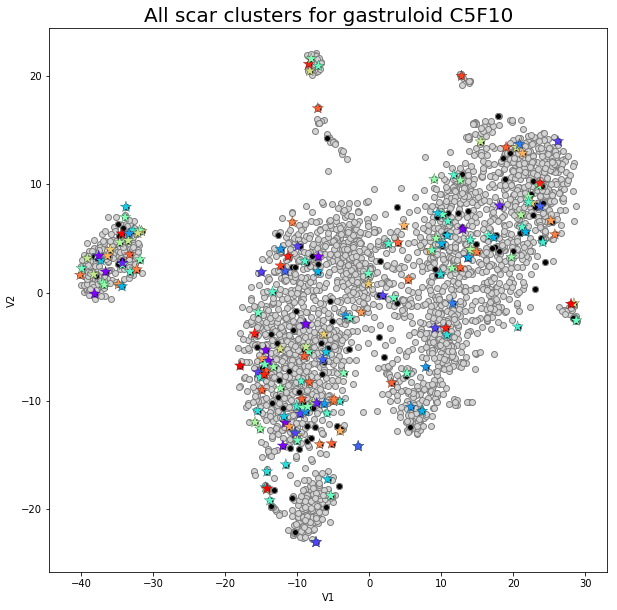

In [72]:
plotAllScarsonTranscriptomeMap('C5F10', 'clust_C5F10')

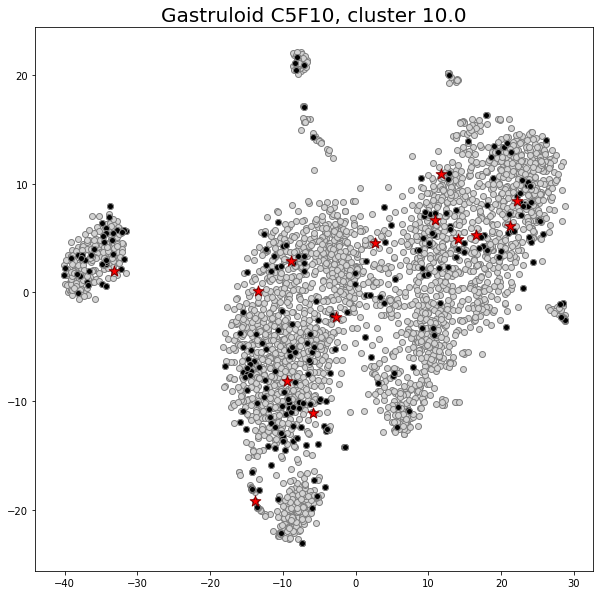

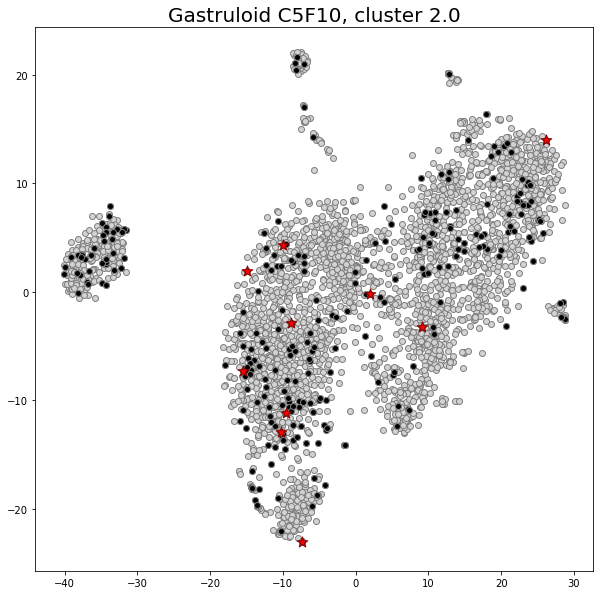

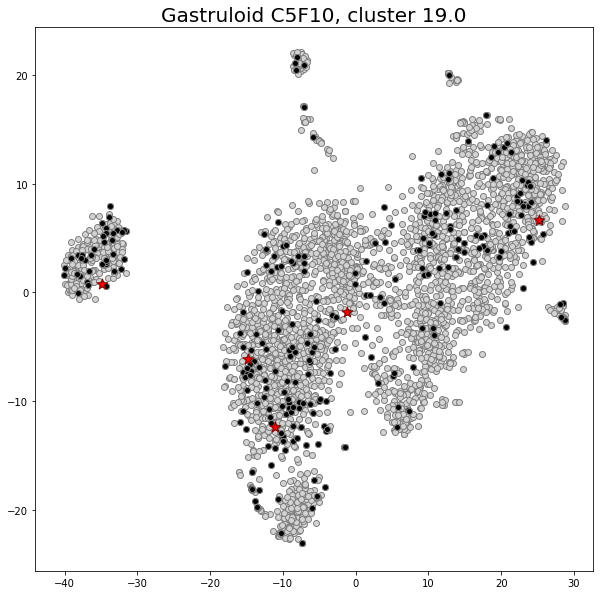

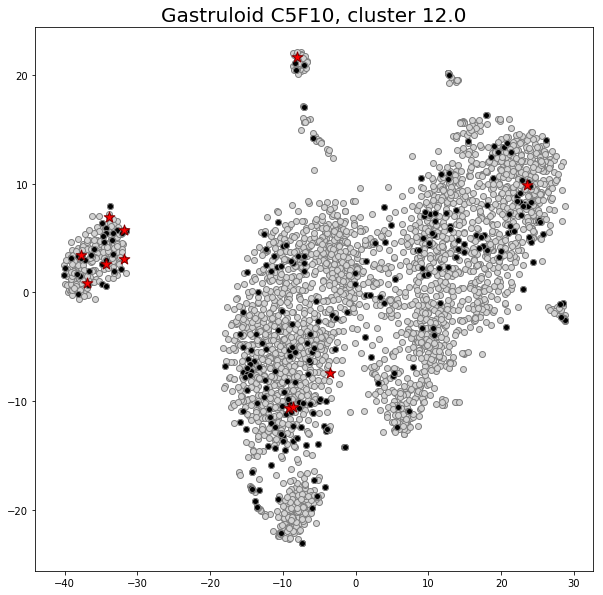

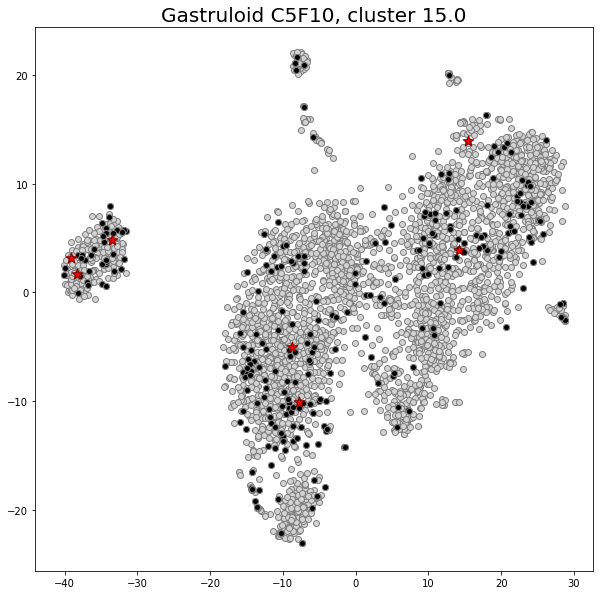

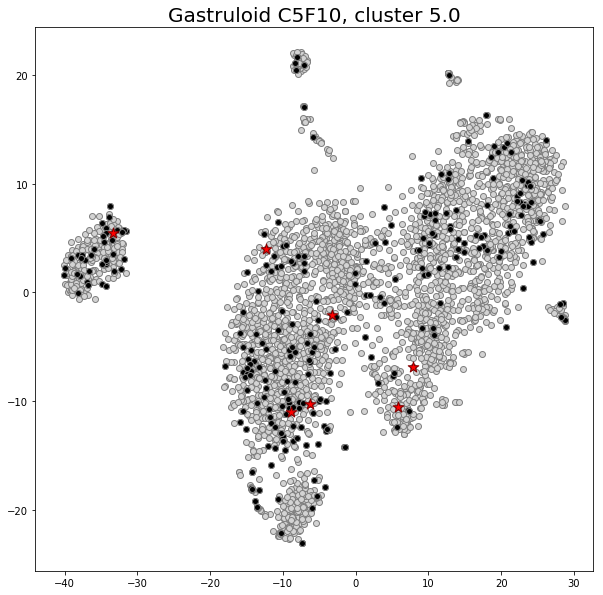

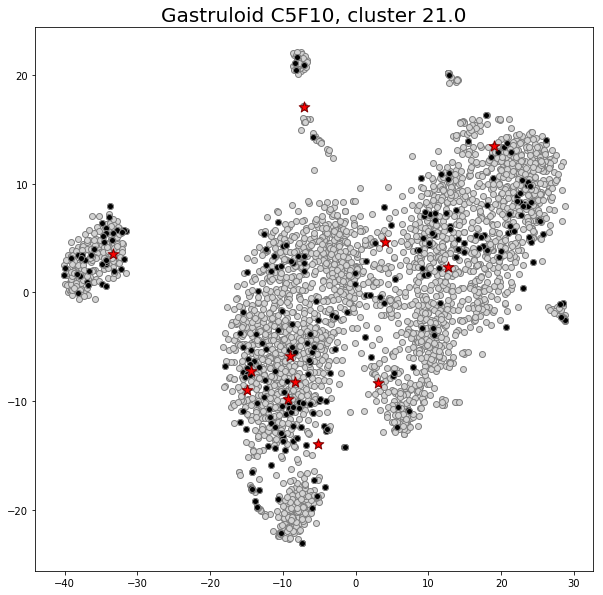

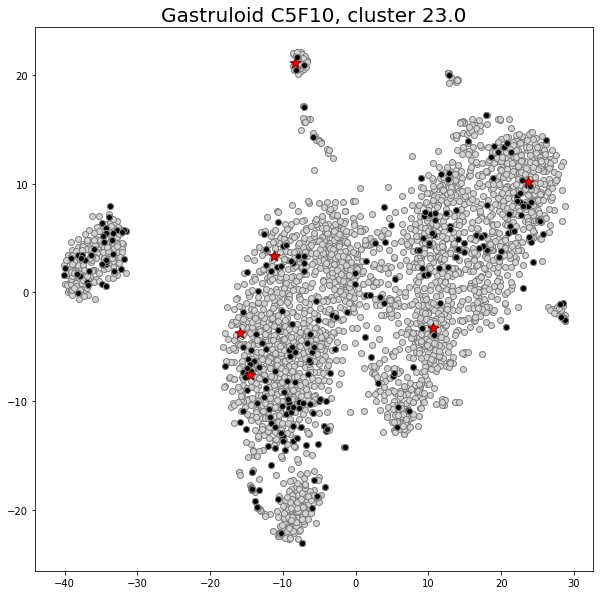

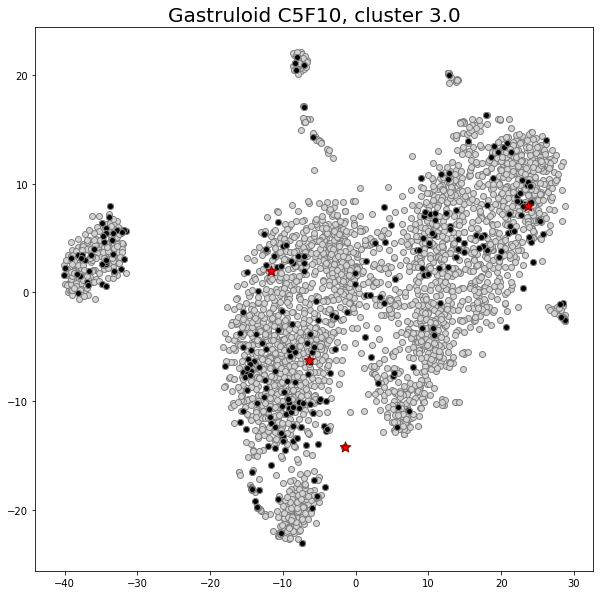

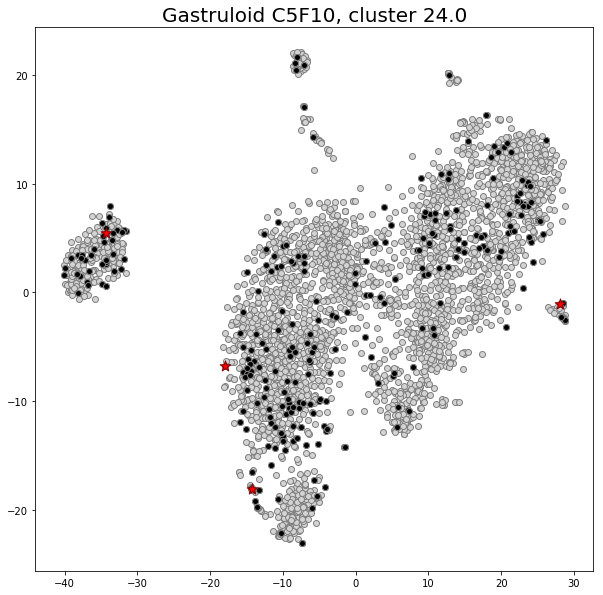

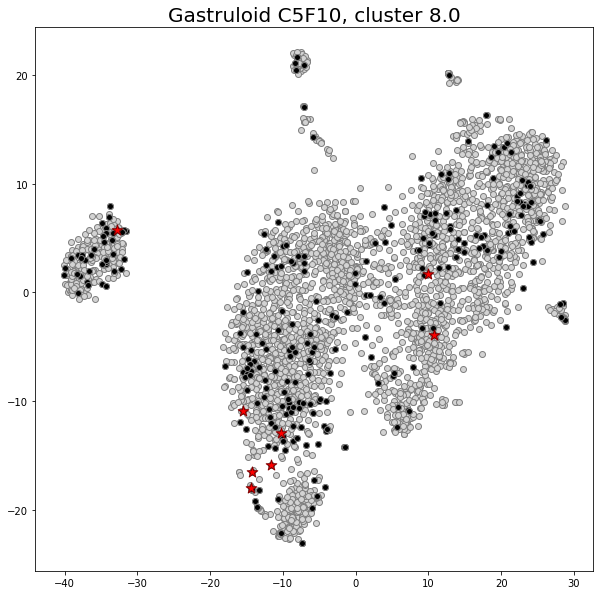

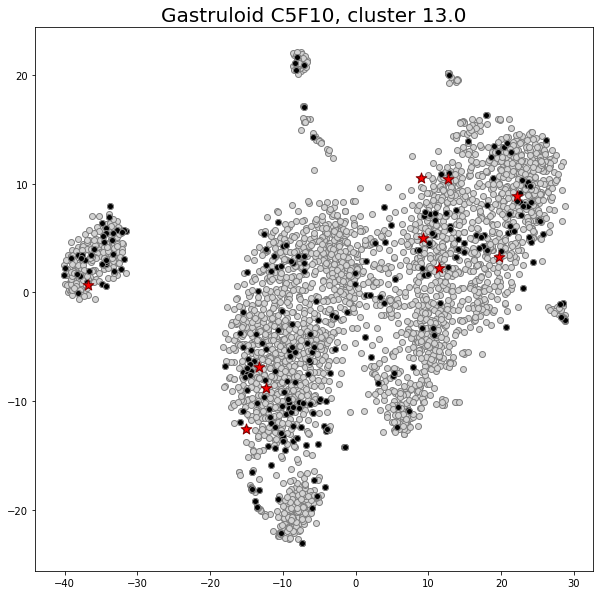

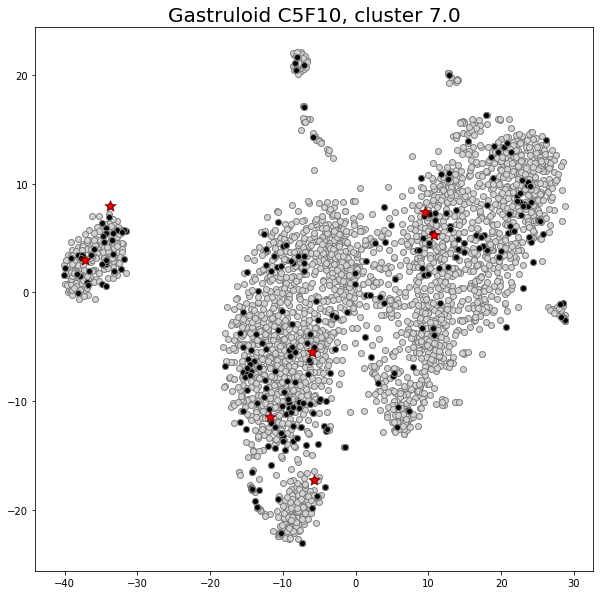

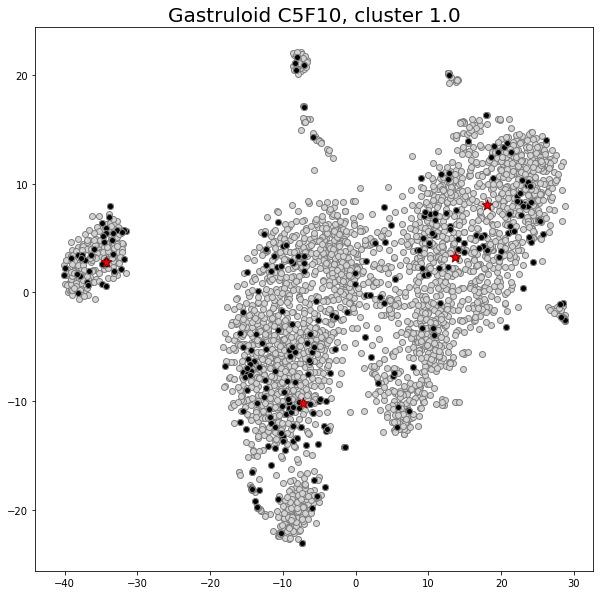

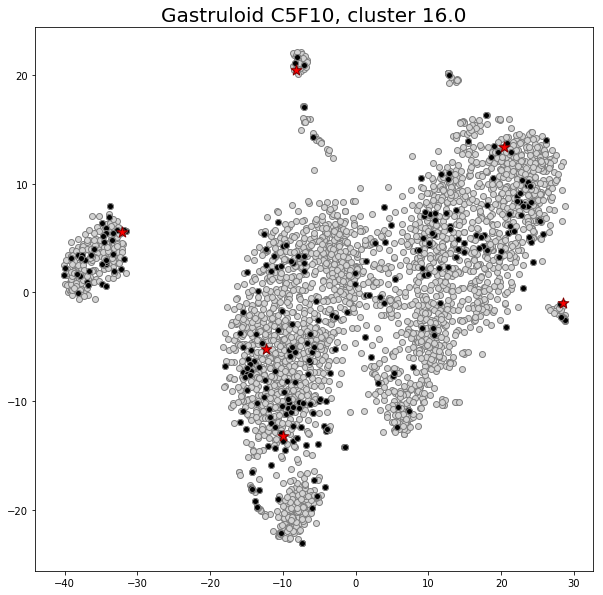

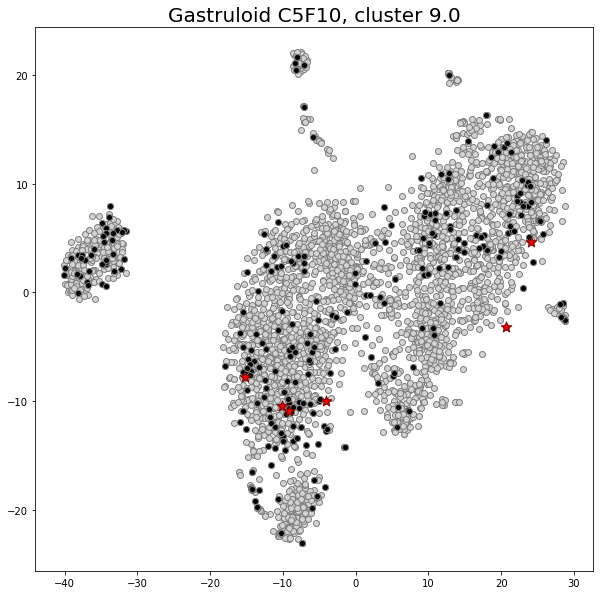

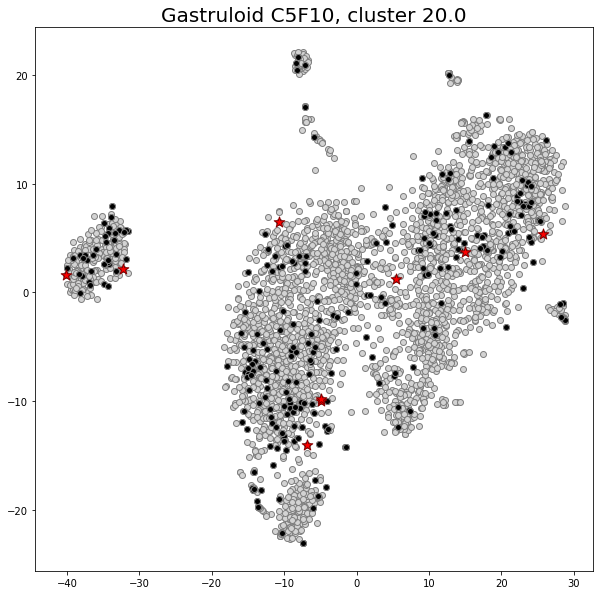

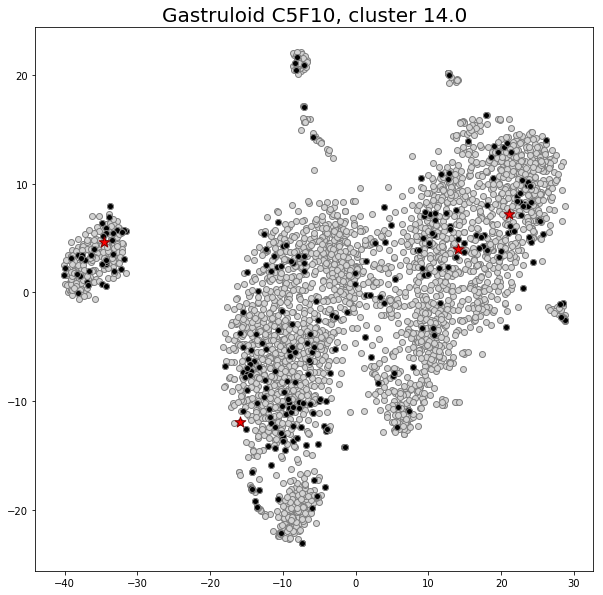

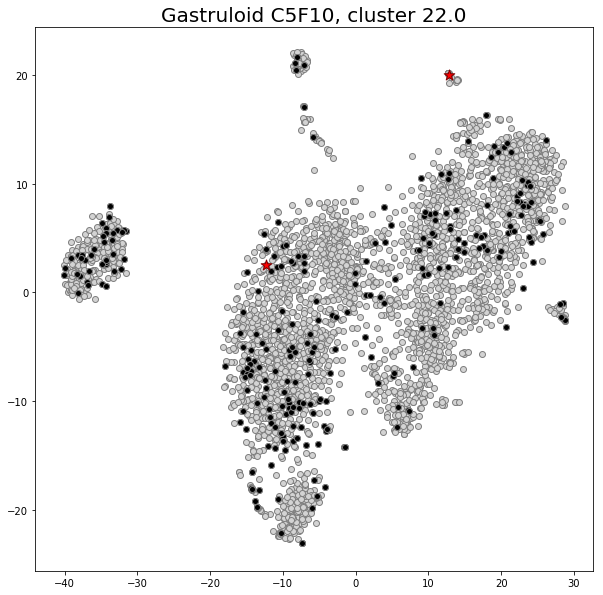

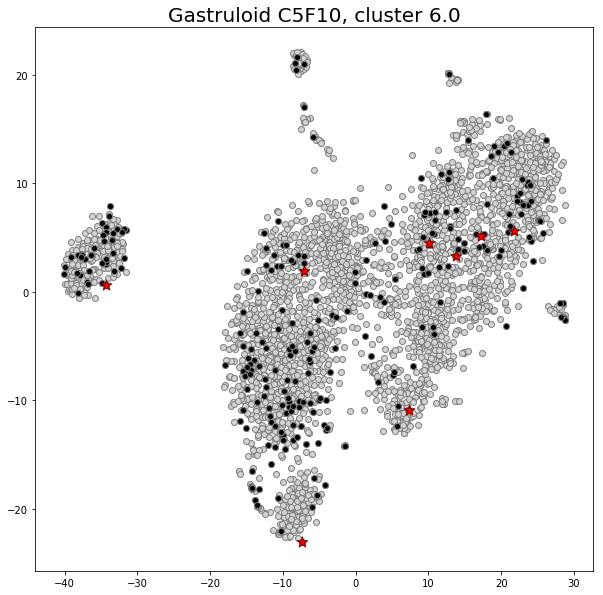

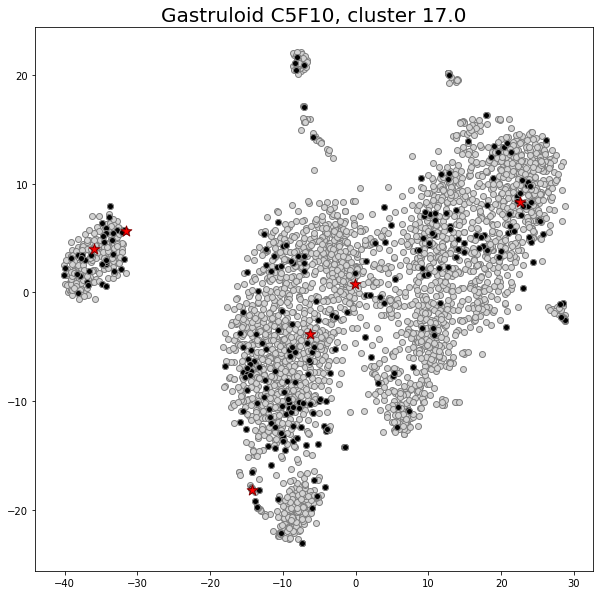

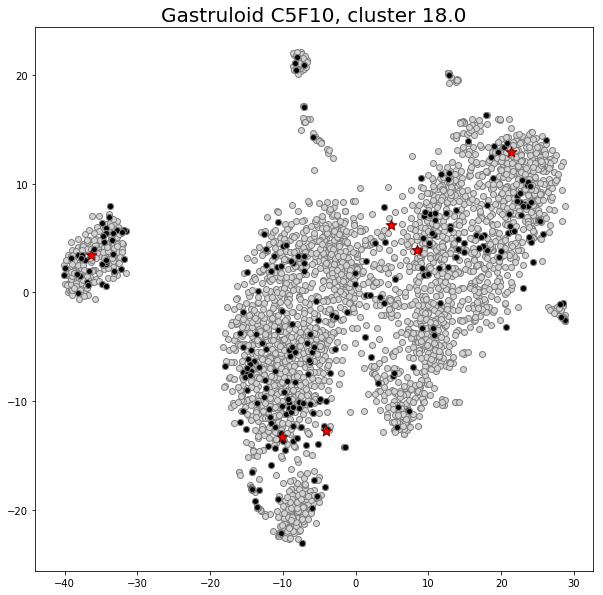

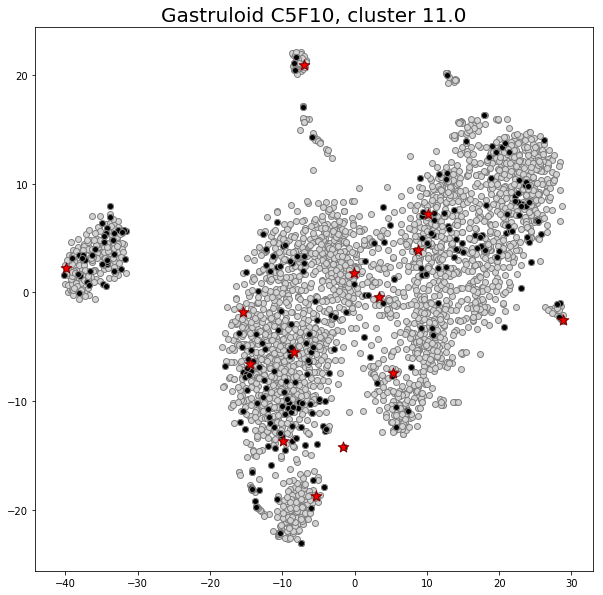

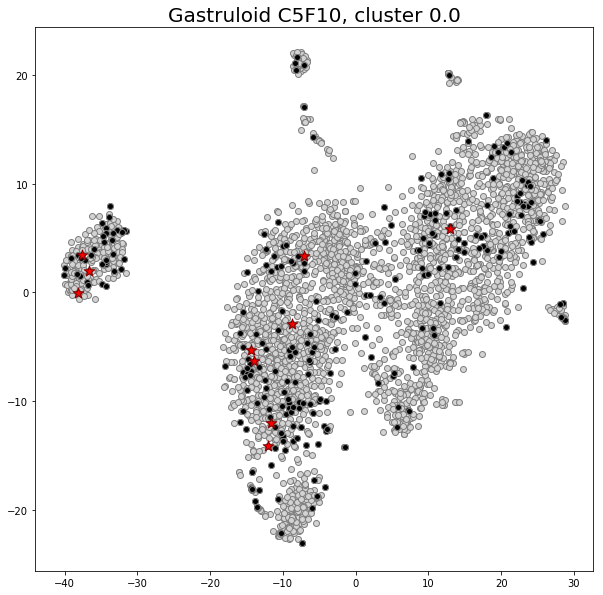

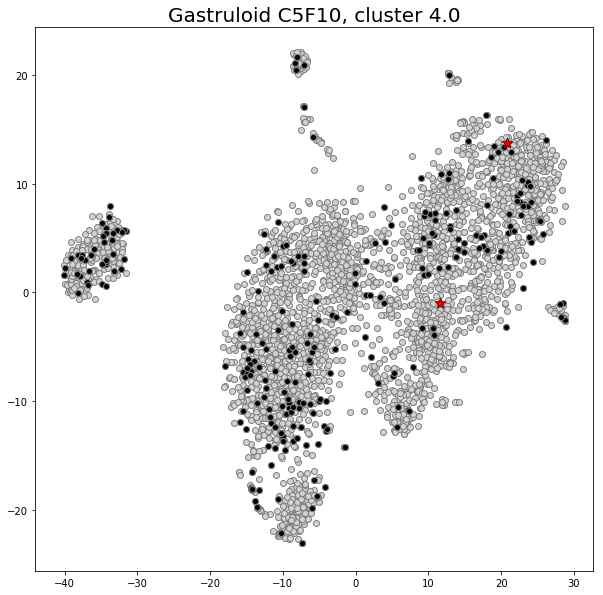

In [77]:
plotPerClusteronTranscriptomeMap('C5F10', 'clust_C5F10')

### For C5A9

In [ ]:
plotAllScarsonTranscriptomeMap('C5A9', 'clust_C5A9')

In [ ]:
plotPerClusteronTranscriptomeMap('C5A9', 'clust_C5A9')

### For C5B10

In [ ]:
plotAllScarsonTranscriptomeMap('C5B10', 'clust_C5B10')

In [ ]:
plotPerClusteronTranscriptomeMap('C5B10', 'clust_C5B10')

### For C5C6

In [ ]:
plotAllScarsonTranscriptomeMap('C5C6', 'clust_C5C6')

In [ ]:
plotPerClusteronTranscriptomeMap('C5C6', 'clust_C5C6')

### For C5G7

In [ ]:
plotAllScarsonTranscriptomeMap('C5G7', 'clust_C5G7')

In [ ]:
plotPerClusteronTranscriptomeMap('C5G7', 'clust_C5G7')

### For C5H11

In [ ]:
plotAllScarsonTranscriptomeMap('C5H11', 'clust_C5H11')

In [ ]:
plotPerClusteronTranscriptomeMap('C5H11', 'clust_C5H11')

### For C5H7

In [ ]:
plotAllScarsonTranscriptomeMap('C5H7', 'clust_C5H7')

In [ ]:
plotPerClusteronTranscriptomeMap('C5H7', 'clust_C5H7')

### For C5H9

In [ ]:
plotAllScarsonTranscriptomeMap('C5H9', 'clust_C5H9')

In [ ]:
plotPerClusteronTranscriptomeMap('C5H9', 'clust_C5H9')